# INSY 670-275 Group Project - FakeNews Detection

In this project we attempt to leverage graph neural networks in combination with a BERT classification model to identify submission nodes (or posts) as fake news or verified news. The initial...




In [1]:
# === Standard Library ===
import os
import io
import ast
import json
import random
from collections import defaultdict, Counter

# === Progress Tracking ===
from tqdm import tqdm

# === Data Handling ===
import pandas as pd
from pandas import json_normalize
import numpy as np


# === Compression ===
import zstandard as zstd

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

# === Natural Language Processing ===
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# === Machine Learning & Preprocessing ===
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, mean_squared_error,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# === Graph Analysis ===
import networkx as nx
import community as community_louvain

# === Deep Learning and GNNs ===
import torch
import dgl

# === Hyperparameter Optimization ===
import optuna

# === Setup ===
nltk.download('vader_lexicon')
pd.set_option('display.max_columns', None)




/home/mack-rock/PycharmProjects/GroupProject/.venv1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to /home/mack-
[nltk_data]     rock/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


*******
## 1. Data Ingestion & Initial Preprocessing
*******

In this stage, we collect and process submissions and comments from the r/politics subreddit. Due to the large size of the dataset, we extract data in manageable blocks to keep memory usage in check. Our focus is on submissions from 2016 to 2018, and we filter related comments based on their submission IDs. Furthermore, we extract records corresponding to posts that were flagged as fake news by a BERT model, in order to designate these as our positive cases for fake news detection. Finally, the filtered and normalized records are written to a JSON file for further analysis.

Then, we filter out rows from the comments and submissions DataFrames where the author is either "AutoModerator" or "[deleted]". This step removes entries from deleted profiles and moderator posts, ensuring that the dataset retains only user-generated content with sufficient information for fake news detection.

In [2]:
submissions_df = pd.read_json("politics_submissions_with_prediction.jsonl", lines=True)
submission_names = set(sid for sid in submissions_df['name'].astype(str))

We will spare you the requirement of streaming all 178 million comments :)

In [3]:
'''

from datetime import datetime

def stream_comments_matching_submissions(
    input_path,
    output_path,
    submission_names,
    is_zst=True,
    chunk_size=100_000,
    valid_years=(2016, 2017, 2018)
):
    read_stream = open(input_path, "rb")
    if is_zst:
        dctx = zstd.ZstdDecompressor()
        read_stream = dctx.stream_reader(read_stream)

    text_reader = io.TextIOWrapper(read_stream, encoding='utf-8')

    buffer = []
    total_count = 0
    matched_count = 0
    seen_keys = set()

    with open(output_path, "w", encoding="utf-8") as out_file:
        for line in text_reader:
            total_count += 1
            try:
                obj = json.loads(line)
                ts = obj.get("created_utc")
                link_id = obj.get("link_id")

                if ts:
                    year = datetime.utcfromtimestamp(ts).year
                    if year in valid_years and link_id in submission_names:
                        seen_keys.update(obj.keys())  # track all keys that ever appear
                        buffer.append(obj)
                        matched_count += 1

                if len(buffer) >= chunk_size:
                    _flush_buffer(buffer, seen_keys, out_file)
                    buffer = []

            except Exception:
                continue

        # Final flush
        if buffer:
            _flush_buffer(buffer, seen_keys, out_file)

    print(f"Done. Matched {matched_count:,} comments out of {total_count:,} total.")
    print(f"Total schema keys preserved: {len(seen_keys)}")

    # Save schema for downstream use
    with open("preserved_comment_schema.json", "w") as schema_file:
        json.dump(sorted(list(seen_keys)), schema_file, indent=2)

    return seen_keys


def _flush_buffer(buffer, all_keys, out_file):
    for record in buffer:
        normalized = {k: record.get(k, None) for k in all_keys}
        json.dump(normalized, out_file)
        out_file.write("\n")
    print(f"Wrote chunk with {len(buffer):,} normalized records")


seen_keys = stream_comments_matching_submissions(
    input_path="politics_comments.zst",
    output_path="politics_comments.jsonl",
    submission_names=submission_names,
    is_zst=True,
    chunk_size=100_000
)

print(seen_keys)
'''

'\n\nfrom datetime import datetime\n\ndef stream_comments_matching_submissions(\n    input_path,\n    output_path,\n    submission_names,\n    is_zst=True,\n    chunk_size=100_000,\n    valid_years=(2016, 2017, 2018)\n):\n    read_stream = open(input_path, "rb")\n    if is_zst:\n        dctx = zstd.ZstdDecompressor()\n        read_stream = dctx.stream_reader(read_stream)\n\n    text_reader = io.TextIOWrapper(read_stream, encoding=\'utf-8\')\n\n    buffer = []\n    total_count = 0\n    matched_count = 0\n    seen_keys = set()\n\n    with open(output_path, "w", encoding="utf-8") as out_file:\n        for line in text_reader:\n            total_count += 1\n            try:\n                obj = json.loads(line)\n                ts = obj.get("created_utc")\n                link_id = obj.get("link_id")\n\n                if ts:\n                    year = datetime.utcfromtimestamp(ts).year\n                    if year in valid_years and link_id in submission_names:\n                       

In [4]:
df_submission = submissions_df.copy()

# Load the politics comments
with open("politics_comments.jsonl", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

# Flatten nested fields too
df_comments = json_normalize(
    data,
    sep=".",
    max_level=2  # expand nested dictionaries/lists
)


print('Comments:\n')
display(df_comments.head())

print('\nSubmissions:\n')
display(df_submission.head())

# Step 1: Ensure name column is created
df_comments["name"] = "t1_" + df_comments["id"].astype(str)
df_submission["name"] = "t3_" + df_submission["id"].astype(str)

Comments:



,link_id,edited,id,created_utc,controversiality,ups,author,gilded,author_flair_text,stickied,author_flair_css_class,retrieved_on,subreddit_id,distinguished,subreddit,parent_id,score,body,can_mod_post,removal_reason,subreddit_type,archived,score_hidden,no_follow,can_gild,permalink,send_replies,author_flair_template_id,is_submitter
0,t3_3yz9nj,False,cyhy11k,1451615256,0,1.0,AutoModerator,0,None,False,None,1454210027,t5_2cneq,moderator,politics,t3_3yz9nj,1,This submission has been automatically removed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,t3_3yzf1w,False,cyhzovj,1451618968,0,2.0,GrindhouseMedia,0,None,False,None,1454210811,t5_2cneq,None,politics,t3_3yzf1w,2,"Thing is, I recall Donald Trump owning propert...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,t3_3yzf1w,False,cyhzpn2,1451619018,1,1.0,OnlyFactsMatter,0,None,False,None,1454210820,t5_2cneq,None,politics,t3_3yzf1w,1,I hope the UK bans him. The UK hasn't been rel...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,t3_3yzf1w,False,cyhzrum,1451619160,0,10.0,CarsonOrSanders,0,None,False,None,1454210849,t5_2cneq,None,politics,t3_3yzf1w,10,&gt;She will continue to use the powers availa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,t3_3yzf1w,False,cyhzz91,1451619638,0,2.0,tenparsecs,0,None,False,None,1454210946,t5_2cneq,None,politics,t3_3yzf1w,2,I submitted the story an hour ago and it got r...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Submissions:



,secure_media,is_self,post_hint,thumbnail,quarantine,retrieved_on,author_flair_css_class,from_kind,permalink,gilded,url,hide_score,secure_media_embed,media_embed,locked,distinguished,from,link_flair_text,id,name,preview,subreddit,num_comments,title,downs,media,saved,score,created_utc,stickied,ups,author,over_18,from_id,edited,archived,author_flair_text,domain,selftext,subreddit_id,link_flair_css_class,contest_mode,spoiler,suggested_sort,brand_safe,hidden,author_cakeday,view_count,thumbnail_height,can_gild,thumbnail_width,is_video,approved_at_utc,banned_at_utc,can_mod_post,is_crosspostable,num_crossposts,parent_whitelist_status,whitelist_status,is_reddit_media_domain,pinned,subreddit_type,crosspost_parent,crosspost_parent_list,mod_note,mod_reason_by,mod_reason_title,original_title,News Verification Status
0,None,True,None,self,0.0,1455008351,None,NaN,/r/politics/comments/41chkw/its_still_saturday...,0,https://www.reddit.com/r/politics/comments/41c...,False,{},{},False,None,NaN,None,41chkw,t3_41chkw,None,politics,33,It's still Saturday here. What about Trumps ec...,0.0,None,0.0,3,2016-01-17 06:53:43,False,3.0,GonzoNation,False,NaN,0,False,None,self.politics,Go ahead. Explain it to me.,t5_2cneq,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,It's still Saturday here. What about Trumps ec...,1
1,"{""type"": ""youtube.com"", ""oembed"": {""url"": ""htt...",False,None,default,0.0,1455036927,None,NaN,/r/politics/comments/430j3i/this_video_will_ma...,0,https://www.youtube.com/watch?v=6ayZBDIvYxE,False,"{""width"": 600, ""height"": 338, ""content"": ""&lt;...","{""width"": 600, ""height"": 338, ""content"": ""&lt;...",False,None,NaN,No ALL CAPS,430j3i,t3_430j3i,None,politics,1,THIS VIDEO WILL MAKE YOU VOTE FOR BERNIE SANDERS,0.0,"{""oembed"": {""provider_url"": ""https://www.youtu...",0.0,1,2016-01-28 00:00:22,False,1.0,mohamud77,False,NaN,0,False,None,youtube.com,,t5_2cneq,nobreakingcaps,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,THIS VIDEO WILL MAKE YOU VOTE FOR BERNIE SANDERS,1
2,None,False,link,http://b.thumbs.redditmedia.com/m8Ew2Hw8_QJ5-L...,0.0,1455045000,None,NaN,/r/politics/comments/43hj50/hillary_clintons_i...,0,https://consortiumnews.com/2016/01/30/hillary-...,False,{},{},False,None,NaN,None,43hj50,t3_43hj50,"{""images"": [{""id"": ""i6fCYolCsDheDXMr8NrxV4o5A_...",politics,4,Hillary Clinton's Iraq War Albatross,0.0,None,0.0,0,2016-01-31 03:37:50,False,0.0,pnw_diver,False,NaN,0,False,None,consortiumnews.com,,t5_2cneq,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,Hillary Clinton's Iraq War Albatross,0
3,None,False,None,default,0.0,1455017732,None,NaN,/r/politics/comments/41w54m/socialism/,0,https://giphy.com/gifs/bernie-sanders-senator-...,False,{},{},False,None,NaN,No Satire,41w54m,t3_41w54m,None,politics,12,Socialism!!!,0.0,None,0.0,13,2016-01-20 20:15:29,False,13.0,unity100,False,NaN,0,False,None,giphy.com,,t5_2cneq,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,Socialism!!!,1
4,None,False,link,http://a.thumbs.redditmedia.com/A6KwOTZ0QM_f8u...,0.0,1454994814,None,NaN,/r/politics/comments/40k01i/the_house_freedom_...,0,http://www.politico.com/story/2016/01/freedom-...,False,{},{},False,None,NaN,None,40k01i,t3_40k01i,"{""images"": [{""id"": ""1D5AWiS1L_tYwj9_yexpLIFE88...",politics,0,The House Freedom Caucus is considering hiring...,0.0,None,0.0,3,2016-01-12 01:06:08,False,3.0,TwoGee,False,NaN,0,False,None,politico.com,,t5_2cneq,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,The House Freedom Caucus is considering hiring...,0


In [5]:
# Handle users that are either the auto moderators or deleted
df_comments = df_comments[(df_comments['author'] != 'AutoModerator') & (df_comments['author'] != '[deleted]') & (df_comments['author'] != 'PoliticsModeratorBot')]
df_submission = df_submission[(df_submission['author'] != '[deleted]') & (df_comments['author'] != 'PoliticsModeratorBot')]

print(df_comments.shape, df_submission.shape)

(658341, 30) (20850, 69)


/tmp/ipykernel_748402/3967436179.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_submission = df_submission[(df_submission['author'] != '[deleted]') & (df_comments['author'] != 'PoliticsModeratorBot')]


*******
## 2. Data Exploration
*******

### 2.1 Directed Graph Representation

Next, we performe EDA on our dataset by transforming the comments and submission dataframes into a directed graph for our initial analysis.
- **Nodes:**
    * Authors/Users from the comments and submissions
- **Edges:**
    * Comments left on submissions, or replys to another comment

We iterate over each comment and determine the parent author based on  `parent_id`, which distinguishes between comment replies and cubmission comments. If a valid parent author exists and is different from the comment's author, an edge is added from the parent author to the comment's author. If the edge already exists, its weight is incremented to reflect multiple interactions.

A visualisation of the network is constructed from a subgraph of the top 500 most weighted interaction & their corresponding nodes.

In [6]:
#created a directed graph of the users
user_graph = nx.DiGraph()

# Create mapping from ID to author
comment_author_map = dict(zip(df_comments['name'].values, df_comments['author'].values))
submission_author_map = dict(zip(df_submission['name'].values, df_submission['author'].values))

# Add all unique users as nodes
all_authors = pd.concat([df_comments['author'], df_submission['author']]).unique()
user_graph.add_nodes_from(all_authors)

# Initialize edge attribute collectors
edge_attr = defaultdict(lambda: defaultdict(list))

# Vectorized pass over comment interactions
for idx in tqdm(range(len(df_comments)), desc="Processing comments"):
    row = df_comments.iloc[idx]
    author = row['author']
    parent_id = row['parent_id']

    if parent_id.startswith('t1_'):
        parent_author = comment_author_map.get(parent_id)
    elif parent_id.startswith('t3_'):
        parent_author = submission_author_map.get(parent_id)
    else:
        parent_author = None

    if parent_author and parent_author != author:
        edge_key = (parent_author, author)

        if user_graph.has_edge(*edge_key):
            user_graph[edge_key[0]][edge_key[1]]['weight'] += 1
        else:
            user_graph.add_edge(edge_key[0], edge_key[1], weight=1)

print(f"User-user graph created with {user_graph.number_of_nodes()} nodes and {user_graph.number_of_edges()} edges")


Processing comments: 100%|██████████| 658341/658341 [00:15<00:00, 42137.90it/s]

User-user graph created with 104993 nodes and 477212 edges


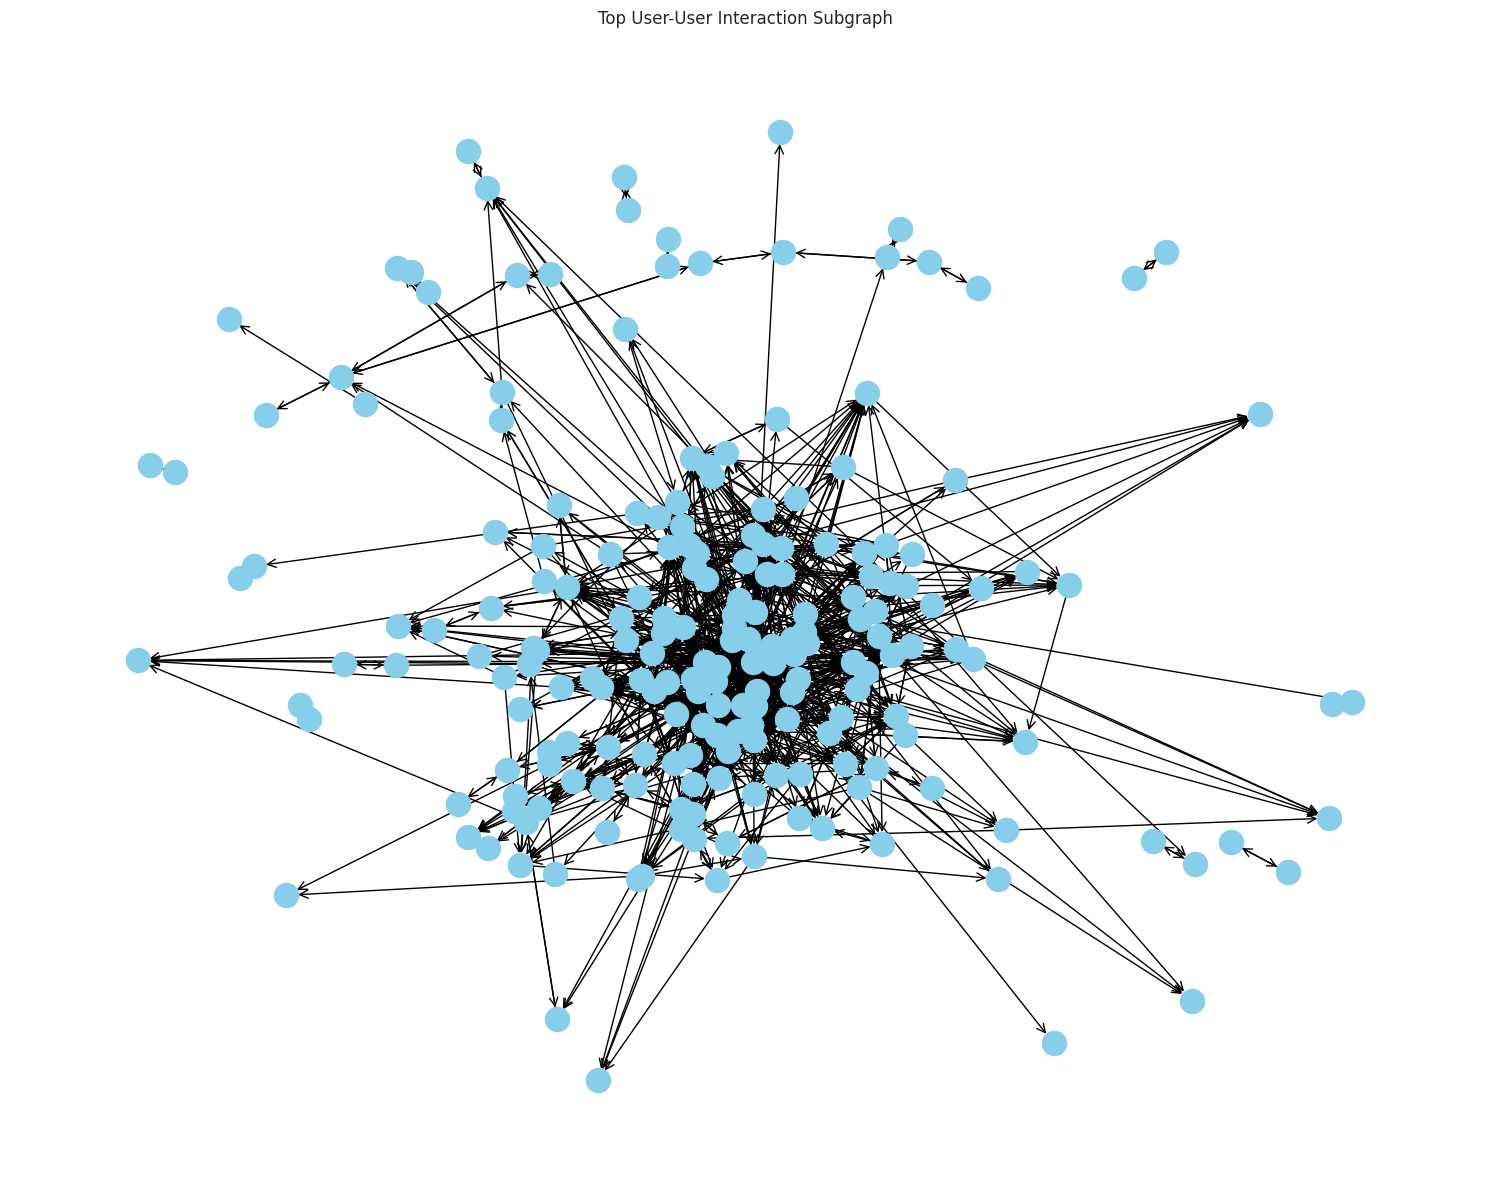

In [7]:
# Select top N edges by weight for clarity
top_n = 200
top_edges = sorted(user_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:top_n]

# Build a subgraph with only those edges
top_authors = set()
for u, v, _ in top_edges:
    top_authors.add(u)
    top_authors.add(v)

subgraph = user_graph.subgraph(top_authors).copy()

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(subgraph, k=0.25, seed=42)

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='skyblue')

# Draw edges with weight-based thickness
nx.draw_networkx_edges(subgraph, pos, arrowstyle='->', arrowsize=15, width=1)

plt.title("Top User-User Interaction Subgraph")
plt.axis('off')
plt.tight_layout()
plt.show()


Please check out the graph in Gephi, very fun



In [8]:
nx.write_graphml(user_graph, "user_interaction_graph.graphml")

### 2.2 Network Graph Metrics

Here we define multiple function to perform an in-depth analysis of a user interaction network by computing multiple centrality measures—including in/out degree, betweenness, eigenvector centrality, and HITS scores—and normalizing them to create a composite influence score for each user. We also detects communities using the Louvain method, calculates additional metrics such as average edge weights and an approximate closeness centrality, and aggregates all these features into a Pandas DataFrame. The analysis further highlights the top influential users and communities by displaying key statistics and visualizing subgraphs of these top users along with their immediate neighbors.

Computing influence..
Measuring in-degree and out-degree..
Measuring betweenness...
Computing eigenvectors...
Detecting communities..
Calculating HITS..
Computing average weights for a user..
Calculating community influence..
Computing additional metrics for a user..
      author  verified_news_score    verified_news_level
1  mohamud77             1.000000  The Deception Peddler
2  pnw_diver             0.000000           Fence Sitter
3   unity100             1.000000  The Deception Peddler
4     TwoGee             0.095238           Fence Sitter
5   geargirl             1.000000  The Deception Peddler


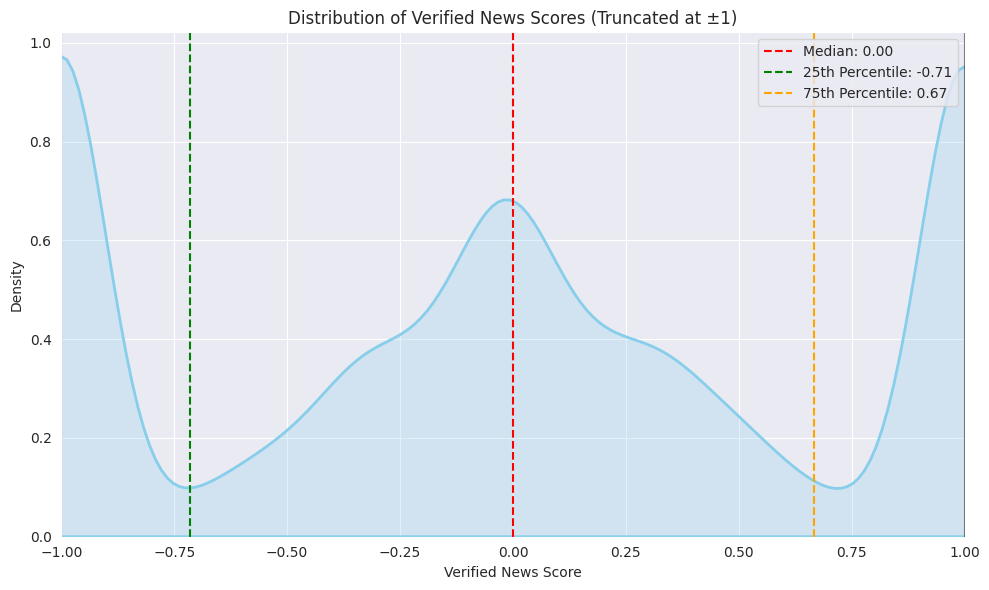

Users with scores beyond ±1: 0 of 20850 (0.00%)


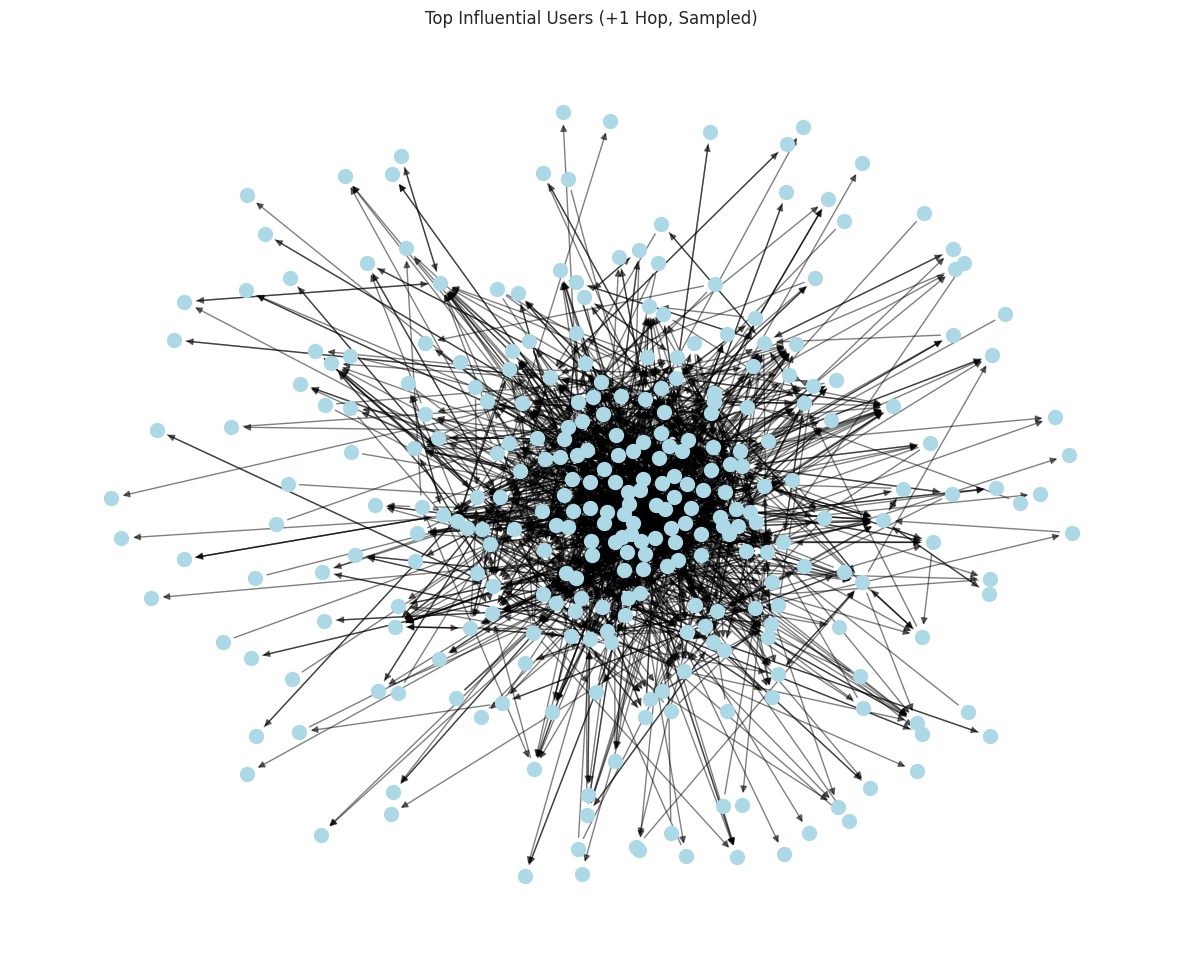


User statistics:
  - Total users: 104993
  - Submission authors: 10680 (10.2%)
  - Comment-only users: 59629 (56.8%)
  - Browser-only users: 34684 (33.0%)

Top 25 Influential Users:


/tmp/ipykernel_748402/1133215736.py:267: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(user_features['verified_news_level']):


,u_influence_score,u_in_degree_norm,u_out_degree_norm,u_betweenness_norm,u_ev_norm,verified_news_score,verified_news_level,is_commenter_only,comment_count
index,,,,,,,,,
druuconian,0.674887,1.000,0.102444,0.597103,1.000000,0.000000,Comment-Only User,True,373
Qu1nlan,0.623468,0.332,1.000000,1.000000,0.161871,0.125000,Fence Sitter,False,3641
escalation,0.554801,0.846,0.058500,0.321343,0.993359,0.000000,Comment-Only User,True,213
pissbum-emeritus,0.433266,0.670,0.056578,0.233466,0.773020,0.000000,Comment-Only User,True,206
watchout5,0.431431,0.702,0.087613,0.322477,0.613634,0.000000,Fence Sitter,False,319
JumpingJazzJam,0.407004,0.654,0.070310,0.250372,0.653333,0.000000,Comment-Only User,True,256
dyzo-blue,0.385360,0.596,0.114254,0.304847,0.526339,0.200000,Fence Sitter,False,416
SATexas1,0.366424,0.564,0.110135,0.334120,0.457442,1.000000,The Deception Peddler,False,401
Trump-Tzu,0.365141,0.590,0.060148,0.202691,0.607726,0.000000,Comment-Only User,True,219



Top 10 by Authority:


,u_authority,verified_news_score,verified_news_level,is_commenter_only,comment_count
index,,,,,
general_malapropos,0.009603,1.0,The Deception Peddler,False,68
Thrall_So_Hard,0.006844,0.0,Comment-Only User,True,71
NDubbaYa,0.005992,0.0,Comment-Only User,True,82
TheWrathofKrieger,0.005227,0.0,Comment-Only User,True,84
BigT5535,0.004917,0.0,Comment-Only User,True,34
Patriots_Sixers,0.004765,-1.0,Credibility Anchor,False,67
Bokononism4Life,0.004761,0.0,Comment-Only User,True,31
Quidfacis_,0.004689,0.0,Comment-Only User,True,63
PSteak,0.004530,0.0,Comment-Only User,True,23



Top 10 by Hub Score:


,u_hub_score,verified_news_score,verified_news_level,is_commenter_only,comment_count
index,,,,,
Qu1nlan,0.358978,0.125000,Fence Sitter,False,3641
PoliticsModeratorBot,0.003725,-0.666667,Credibility Anchor,False,1386
radicalheadphone,0.002444,1.000000,The Deception Peddler,False,110
Thrall_So_Hard,0.002375,0.000000,Comment-Only User,True,71
Patriots_Sixers,0.001987,-1.000000,Credibility Anchor,False,67
golikehellmachine,0.001973,0.000000,Comment-Only User,True,176
Animblenavigator,0.001894,0.600000,Lie Spinner,False,80
Bokononism4Life,0.001892,0.000000,Comment-Only User,True,31
AwkwardBurritoChick,0.001832,0.000000,Comment-Only User,True,42


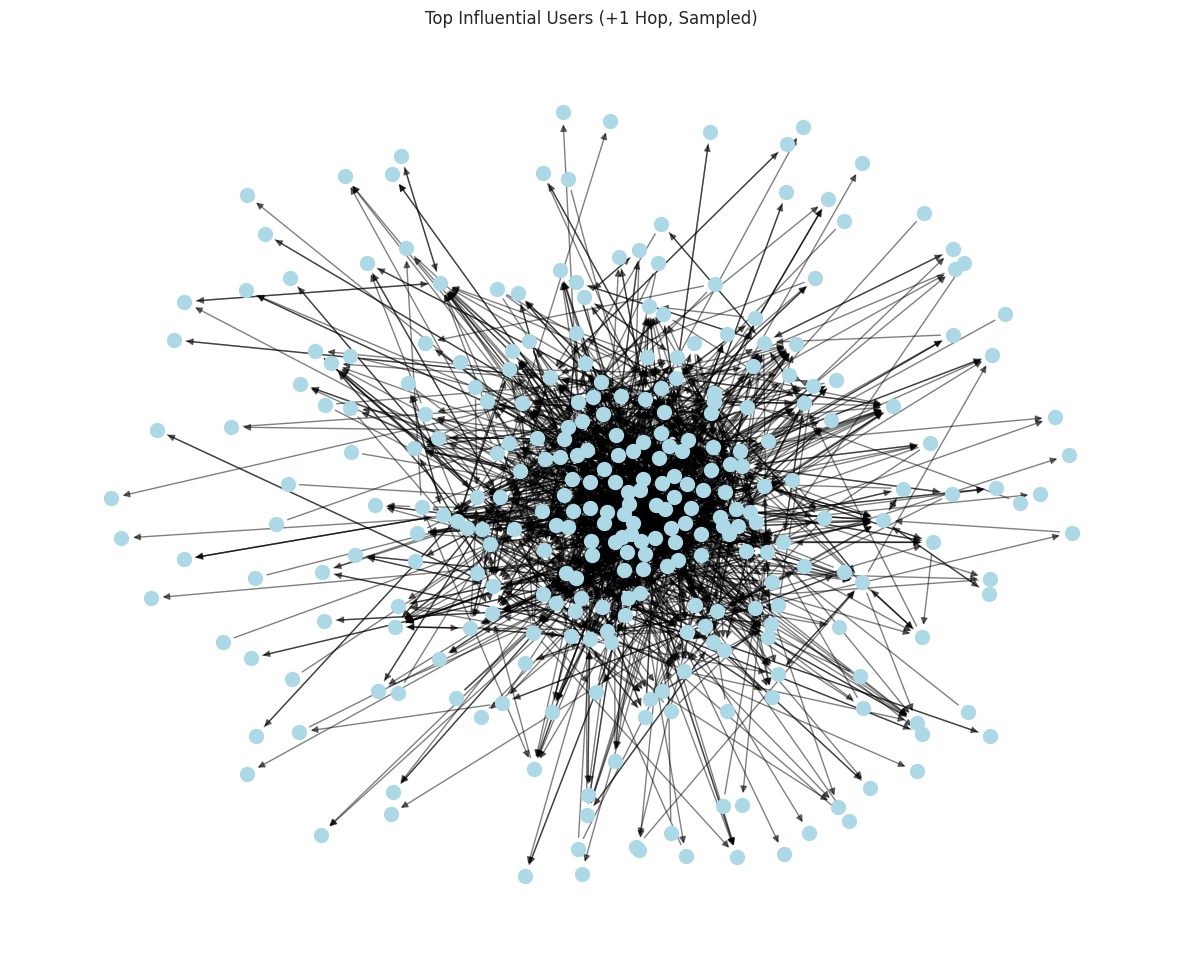


Sample Users from Top 100 Influential Communities:


,u_influence_score,u_community_influence,verified_news_score,verified_news_level,is_commenter_only,comment_count
index,,,,,,
GrindhouseMedia,0.001417,0.007135,-1.0,Credibility Anchor,False,7
OnlyFactsMatter,0.110422,0.007135,1.0,The Deception Peddler,False,96
CarsonOrSanders,0.128409,0.007135,0.0,Comment-Only User,True,137
HeroUser,0.015202,0.007135,1.0,The Deception Peddler,False,25
HumEatsHillyAndPukes,0.000510,0.007135,0.0,Browser,True,0
...,...,...,...,...,...,...
Kleptosporidium,0.000500,0.000284,0.0,Browser,True,0
JustAnotherYesterday,0.000069,0.000284,0.0,Comment-Only User,True,1
Captain_Phist,0.000500,0.000284,0.0,Browser,True,0


In [9]:
def normalize_dict(d):
    max_val = max(d.values()) if d else 1
    return {k: v / max_val for k, v in d.items()}


### Centrality Measures
def compute_influence_metrics(user_graph):
    '''
    #compute influence metric utilizing various degree metrics to measure the level of interaction, the role a user plays as a member of the community (are they a intermediary, etc., the level of influence of their closest neighbours
    '''

    print('Measuring in-degree and out-degree..')
    in_degree = dict(user_graph.in_degree())
    out_degree = dict(user_graph.out_degree())

    print('Measuring betweenness...')
    betweenness = nx.betweenness_centrality(user_graph, k=2000, seed=42)

    print('Computing eigenvectors...')
    try:
        eigenvector = nx.eigenvector_centrality(user_graph, max_iter=100, tol=1e-06)
    except nx.NetworkXException as e:
        print("Eigenvector centrality failed:", e)
        eigenvector = {node: 0 for node in user_graph.nodes()}


    in_norm = normalize_dict(in_degree)
    out_norm = normalize_dict(out_degree)
    bet_norm = normalize_dict(betweenness)
    eigenvector_norm = normalize_dict(eigenvector)

    influence_score = {
        node: (in_norm.get(node, 0) + out_norm.get(node, 0) + bet_norm.get(node, 0) + eigenvector_norm.get(node, 0)) / 4
        for node in user_graph.nodes()
    }


    norm_scores = pd.DataFrame({
        'u_in_degree_norm': pd.Series(in_norm),
        'u_out_degree_norm': pd.Series(out_norm),
        'u_betweenness_norm': pd.Series(bet_norm),
        'u_ev_norm': pd.Series(eigenvector_norm),
    })

    return in_degree, out_degree, betweenness, eigenvector, influence_score, norm_scores


### Louvain Community detections
def detect_communities(user_graph):
    #use louvain community detection to detect subcommunities and subgraphs
    if community_louvain:
        return community_louvain.best_partition(user_graph.to_undirected())
    else:
        return {n: 0 for n in user_graph.nodes()}


### HITS
def compute_hits_scores(user_graph): #compute hits for the nodes
    return nx.hits(user_graph, max_iter=1000)


### Average weight per node
def compute_average_edge_weights(user_graph):
    avg_weight = {} #computing the average edge weights of a user - how often do they interact with the same individuals
    for node in user_graph.nodes():
        edges = user_graph.out_edges(node, data=True)
        weights = [e.get('weight', 1) for _, _, e in edges]
        avg_weight[node] = np.mean(weights) if weights else 0
    return avg_weight


### Community Influence
def compute_community_influence(partition, influence_score):
    from collections import defaultdict
    from concurrent.futures import ThreadPoolExecutor

    community_influence = defaultdict(list)

    def accumulate(node):
        community_id = partition[node]
        community_influence[community_id].append(influence_score[node])

    with ThreadPoolExecutor() as executor:
        executor.map(accumulate, partition.keys())

    return {k: np.mean(v) for k, v in community_influence.items()}


### Closeness centrality
def compute_additional_metrics(user_graph):
    import random

    # Approximate closeness centrality using sampling
    try:
        sampled_nodes = random.sample(list(user_graph.nodes()), min(1000, len(user_graph)))
        sampled_closeness = {n: nx.closeness_centrality(user_graph, u=n) for n in sampled_nodes}
        default_value = np.mean(list(sampled_closeness.values()))
        closeness = {node: sampled_closeness.get(node, default_value) for node in user_graph.nodes()}
    except Exception as e:
        print("Closeness centrality calculation failed:", e)
        closeness = {node: 0 for node in user_graph.nodes()}

    return closeness


### Network Visualization
def visualize_top_nodes(user_graph, top_nodes, max_neighbors=2, max_nodes=300):
    sub_nodes = set(top_nodes)
    for node in top_nodes:
        # Limit number of neighbors pulled
        successors = list(user_graph.successors(node))[:max_neighbors]
        predecessors = list(user_graph.predecessors(node))[:max_neighbors]
        sub_nodes.update(successors + predecessors)
        if len(sub_nodes) >= max_nodes:
            break

    subgraph = user_graph.subgraph(sub_nodes)
    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(subgraph, k=0.4, seed=42)
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='lightblue')
    nx.draw_networkx_edges(subgraph, pos, arrows=True, width=1, alpha=0.5)
    plt.title("Top Influential Users (+1 Hop, Sampled)")
    plt.axis('off')
    plt.show()

def verification_status(df_submission_copy):
        # Count the number of times News Verification Status is 1 and 0 for each author
    verification_counts = df_submission_copy.groupby('author')['News Verification Status'].value_counts().unstack(fill_value=0)
    verification_counts.columns = ['verification_status_0', 'verification_status_1']

    # Add a column for the total number of posts by each author
    verification_counts['total_posts_r/politics'] = verification_counts['verification_status_0'] + verification_counts['verification_status_1']

    # Merge without duplicating columns
    df_submission_copy= df_submission_copy.merge(verification_counts, left_on='author', right_index=True, how='left', suffixes=('', '_drop'))

    # Detele duplicate columns
    df_submission_copy = df_submission_copy.drop(columns=['verification_status_0_x', 'verification_status_1_x', 'total_posts_r/politics_x', 'verification_status_0_y', 'verification_status_1_y', 'total_posts_r/politics_y', 'verificationstatus_0_new','verificationstatus_`_new'], errors='ignore')

    # Verify the result
    #print(df_submission.head(50))

    # Calculate the Verified News Source Score
    df_submission_copy['verified_news_score'] = (
        (df_submission_copy['verification_status_1'] - df_submission_copy['verification_status_0']) /
        df_submission_copy['total_posts_r/politics']
    )

    # Define bins and labels for the score
    bins = [-1.1, -0.6, -0.2, 0.2, 0.6, 1.1]
    labels = ['Credibility Anchor', 'Fact Wielder', 'Fence Sitter', 'Lie Spinner', 'The Deception Peddler']

    # Bin the scores into 5 levels
    df_submission_copy['verified_news_level'] = pd.cut(df_submission_copy['verified_news_score'], bins=bins, labels=labels)

    # Display the result
    print(df_submission_copy[['author', 'verified_news_score', 'verified_news_level']].head(5))

    # Count the total number of entries in each bin
    bin_counts = df_submission_copy['verified_news_level'].value_counts()

    # # Count NaN values in verified_news_level
    # nan_count = df_submission['verified_news_level'].isna().sum()
    # print(f"Number of NaN values in 'verified_news_level': {nan_count}")

    # Use the 'verified_news_score' column as scores
    scores = df_submission_copy['verified_news_score']

    # Calculate statistics
    median_score = scores.median()
    percentile_25 = np.percentile(scores, 25)
    percentile_75 = np.percentile(scores, 75)


    # Create the plot with limited x-axis range
    plt.figure(figsize=(10, 6))
    sns.kdeplot(scores, fill=True, color="skyblue", linewidth=2)

    # Add vertical lines for median and percentiles
    plt.axvline(median_score, color='red', linestyle='--', label=f'Median: {median_score:.2f}')
    plt.axvline(percentile_25, color='green', linestyle='--', label=f'25th Percentile: {percentile_25:.2f}')
    plt.axvline(percentile_75, color='orange', linestyle='--', label=f'75th Percentile: {percentile_75:.2f}')

    # Set x-axis limits to exactly -1 and 1
    plt.xlim(-1, 1)

    # Add vertical lines at boundaries
    plt.axvline(-1, color='black', linestyle='-', alpha=0.5)
    plt.axvline(1, color='black', linestyle='-', alpha=0.5)

    # Labels and title
    plt.title('Distribution of Verified News Scores (Truncated at ±1)')
    plt.xlabel('Verified News Score')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: Show count of users beyond the limits
    beyond_limits = len(df_submission_copy[(df_submission_copy['verified_news_score'] > 1) |
                                     (df_submission_copy['verified_news_score'] < -1)])
    total_users = len(df_submission_copy)
    print(f"Users with scores beyond ±1: {beyond_limits} of {total_users} ({beyond_limits/total_users:.2%})")

    df_submission_copy.drop_duplicates(subset=['author'], inplace=True)

    return df_submission_copy


def analyze_user_graph(user_graph, df_submission):

    '''
    Run the analysis on the user graph
    Retain the metrics of the graph
    Add these to a dataframe called user features which will be added to later on
    Display all of the outputs of the above functions
    '''
    print('Computing influence..')
    in_deg, out_deg, bet, ev, influence, norm_scores = compute_influence_metrics(user_graph)
    print('Detecting communities..')
    partition = detect_communities(user_graph)
    print('Calculating HITS..')
    hits_hub, hits_auth = compute_hits_scores(user_graph)
    print('Computing average weights for a user..')
    avg_weights = compute_average_edge_weights(user_graph)
    print('Calculating community influence..')
    comm_influence = compute_community_influence(partition, influence)
    print('Computing additional metrics for a user..')
    closeness = compute_additional_metrics(user_graph)

    user_features = pd.DataFrame({
        'u_in_degree': pd.Series(in_deg),
        'u_out_degree': pd.Series(out_deg),
        'u_betweenness': pd.Series(bet),
        'u_ev': pd.Series(ev),
        'u_influence_score': pd.Series(influence),
        'u_community': pd.Series(partition),
        'u_authority': pd.Series(hits_auth),
        'u_hub_score': pd.Series(hits_hub),
        'u_avg_edge_weight': pd.Series(avg_weights),
        'u_closeness': pd.Series(closeness)
    })

    user_features['u_community_influence'] = user_features['u_community'].map(comm_influence)
    user_features = user_features.join(norm_scores, how='left')

    df_submission_copy = verification_status(df_submission)

    # Visualize top 100 by influence (+1 hop)
    top_100 = user_features.sort_values('u_influence_score', ascending=False).head(100).index.tolist()
    visualize_top_nodes(user_graph, top_100)

    #Merge verified_news_score and verified_news_level into user_features
    user_features = user_features.reset_index().merge(
        df_submission_copy[['author', 'verification_status_0', 'verification_status_1', 'verified_news_score', 'verified_news_level']],
        left_on='index',
        right_on='author',
        how='left'
    ).set_index('index')


    # Identify commenters vs submitters more explicitly
    user_features['is_commenter_only'] = user_features['author'].isna()
    user_features['comment_count'] = user_features['u_out_degree']

    # Handle categorical conversion first if needed
    if pd.api.types.is_categorical_dtype(user_features['verified_news_level']):
        user_features['verified_news_level'] = user_features['verified_news_level'].astype(str)

    # Create masks for different user types
    comment_only_mask = user_features['is_commenter_only']
    active_commenter_mask = comment_only_mask & (user_features['comment_count'] > 0)
    browser_mask = comment_only_mask & (user_features['comment_count'] == 0)

    # Apply labels based on user type
    user_features.loc[active_commenter_mask, 'verified_news_level'] = 'Comment-Only User'
    user_features.loc[browser_mask, 'verified_news_level'] = 'Browser'
    user_features.loc[comment_only_mask, 'verified_news_score'] = 0

    # Handle any remaining NaNs (for safety)
    user_features['verified_news_score'] = user_features['verified_news_score'].fillna(0)
    user_features['verified_news_level'] = user_features['verified_news_level'].fillna('Comment-Only User')

    # Find users with extreme scores
    extreme_scores = user_features[
        (user_features['verified_news_score'] > 1) |
        (user_features['verified_news_score'] < -1)
    ]

    if len(extreme_scores) > 0:
        print(f"\nFound {len(extreme_scores)} users with extreme scores (beyond ±1):")
        display(extreme_scores[['verified_news_score', 'verified_news_level', 'comment_count']])

    # Create filtered versions
    submitter_users = user_features[~user_features['is_commenter_only']].copy()
    commenter_users = user_features[active_commenter_mask].copy()
    browser_users = user_features[browser_mask].copy()

    print(f"\nUser statistics:")
    print(f"  - Total users: {len(user_features)}")
    print(f"  - Submission authors: {len(submitter_users)} ({len(submitter_users)/len(user_features):.1%})")
    print(f"  - Comment-only users: {len(commenter_users)} ({len(commenter_users)/len(user_features):.1%})")
    print(f"  - Browser-only users: {len(browser_users)} ({len(browser_users)/len(user_features):.1%})")

    # Display top 25 by influence
    top_25_influence = user_features.sort_values('u_influence_score', ascending=False).head(25)
    print("\nTop 25 Influential Users:")
    display(top_25_influence[[
        'u_influence_score', 'u_in_degree_norm', 'u_out_degree_norm', 'u_betweenness_norm', 'u_ev_norm',
        'verified_news_score', 'verified_news_level', 'is_commenter_only', 'comment_count'
    ]])

    # Display top 10 by authority and hub
    print("\nTop 10 by Authority:")
    display(user_features.sort_values('u_authority', ascending=False).head(10)[[
        'u_authority', 'verified_news_score', 'verified_news_level', 'is_commenter_only', 'comment_count'
    ]])
    print("\nTop 10 by Hub Score:")
    display(user_features.sort_values('u_hub_score', ascending=False).head(10)[[
        'u_hub_score', 'verified_news_score', 'verified_news_level', 'is_commenter_only', 'comment_count'
    ]])

    # Visualize top 100 by influence (+1 hop)
    top_100 = user_features.sort_values('u_influence_score', ascending=False).head(100).index.tolist()
    visualize_top_nodes(user_graph, top_100)

    # Display 5 members from top 100 communities by influence
    top_communities = user_features.groupby('u_community')['u_community_influence'].mean().nlargest(100).index
    community_samples = []
    for comm in top_communities:
        members = user_features[user_features['u_community'] == comm].head(5)
        community_samples.append(members)

    print("\nSample Users from Top 100 Influential Communities:")
    display(pd.concat(community_samples)[[
        'u_influence_score', 'u_community_influence', 'verified_news_score', 'verified_news_level',
        'is_commenter_only', 'comment_count'
    ]])

    return user_features


user_features = analyze_user_graph(user_graph, df_submission)

In [10]:
display(user_features)
user_features['u_comment_only'] = user_features['is_commenter_only']
user_features.drop(columns = ['is_commenter_only'], inplace=True)

,u_in_degree,u_out_degree,u_betweenness,u_ev,u_influence_score,u_community,u_authority,u_hub_score,u_avg_edge_weight,u_closeness,u_community_influence,u_in_degree_norm,u_out_degree_norm,u_betweenness_norm,u_ev_norm,author,verification_status_0,verification_status_1,verified_news_score,verified_news_level,is_commenter_only,comment_count
index,,,,,,,,,,,,,,,,,,,,,,
GrindhouseMedia,1,7,0.000006,2.087997e-04,1.417451e-03,0,4.560991e-09,0.000011,1.000000,0.102914,7.134661e-03,0.002,0.001923,0.000264,1.483652e-03,GrindhouseMedia,1.0,0.0,-1.000000,Credibility Anchor,False,7
OnlyFactsMatter,83,96,0.001758,2.352970e-02,1.104222e-01,0,4.018447e-06,0.000236,2.093750,0.102914,7.134661e-03,0.166,0.026366,0.082129,1.671933e-01,OnlyFactsMatter,0.0,1.0,1.000000,The Deception Peddler,False,96
CarsonOrSanders,114,137,0.000786,2.973408e-02,1.284089e-01,0,5.087503e-06,0.000319,1.759124,0.102914,7.134661e-03,0.228,0.037627,0.036729,2.112792e-01,NaN,NaN,NaN,0.000000,Comment-Only User,True,137
tenparsecs,92,66,0.000362,1.946798e-02,8.934286e-02,1,2.021830e-06,0.000050,1.257576,0.102914,4.926230e-03,0.184,0.018127,0.016912,1.383322e-01,tenparsecs,1.0,2.0,0.333333,Lie Spinner,False,66
GeneticsGuy,128,158,0.001264,3.367707e-02,1.494423e-01,2,3.117545e-04,0.000241,1.113924,0.102914,6.060992e-03,0.256,0.043395,0.059078,2.392967e-01,GeneticsGuy,1.0,3.0,0.500000,Lie Spinner,False,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nightshade09,0,0,0.000000,2.238823e-15,3.977060e-15,7999,-0.000000e+00,-0.000000,0.000000,0.102914,3.977060e-15,0.000,0.000000,0.000000,1.590824e-14,Nightshade09,0.0,1.0,1.000000,The Deception Peddler,False,0
mathemology,0,0,0.000000,2.238823e-15,3.977060e-15,8000,-0.000000e+00,-0.000000,0.000000,0.102914,3.977060e-15,0.000,0.000000,0.000000,1.590824e-14,mathemology,1.0,0.0,-1.000000,Credibility Anchor,False,0
gitbse,0,0,0.000000,2.238823e-15,3.977060e-15,10,-0.000000e+00,-0.000000,0.000000,0.102914,3.977060e-15,0.000,0.000000,0.000000,1.590824e-14,gitbse,0.0,1.0,1.000000,The Deception Peddler,False,0


### 3. Adressing missing values and Correlation

This code processes the comments and submissions datasets by first flattening any nested JSON structures and converting boolean columns to integers. It then analyzes data quality by identifying columns with high missingness or low variability, and visualizes numeric correlations through a heatmap while highlighting highly correlated feature pairs.

For the comments table: 

Missingness Summary:


,column,missing_percent
can_mod_post,can_mod_post,100.0
archived,archived,100.0
is_submitter,is_submitter,100.0
author_flair_template_id,author_flair_template_id,100.0
send_replies,send_replies,100.0
removal_reason,removal_reason,100.0
permalink,permalink,100.0
can_gild,can_gild,100.0
subreddit_type,subreddit_type,100.0
no_follow,no_follow,100.0



Unary Columns Summary:


,column,unary_percent
subreddit_id,subreddit_id,100.00
send_replies,send_replies,100.00
score_hidden,score_hidden,100.00
archived,archived,100.00
subreddit_type,subreddit_type,100.00
removal_reason,removal_reason,100.00
can_mod_post,can_mod_post,100.00
permalink,permalink,100.00
subreddit,subreddit,100.00
distinguished,distinguished,100.00



For the submission table: 

Missingness Summary:


,column,missing_percent
mod_reason_by,mod_reason_by,100.00
approved_at_utc,approved_at_utc,100.00
from_id,from_id,100.00
mod_note,mod_note,100.00
view_count,view_count,100.00
from_kind,from_kind,100.00
from,from,100.00
mod_reason_title,mod_reason_title,100.00
banned_at_utc,banned_at_utc,100.00
suggested_sort,suggested_sort,99.98



Unary Columns Summary:


,column,unary_percent
subreddit,subreddit,100.00
subreddit_id,subreddit_id,100.00
approved_at_utc,approved_at_utc,100.00
stickied,stickied,100.00
from,from,100.00
from_id,from_id,100.00
archived,archived,100.00
view_count,view_count,100.00
from_kind,from_kind,100.00
mod_note,mod_note,100.00


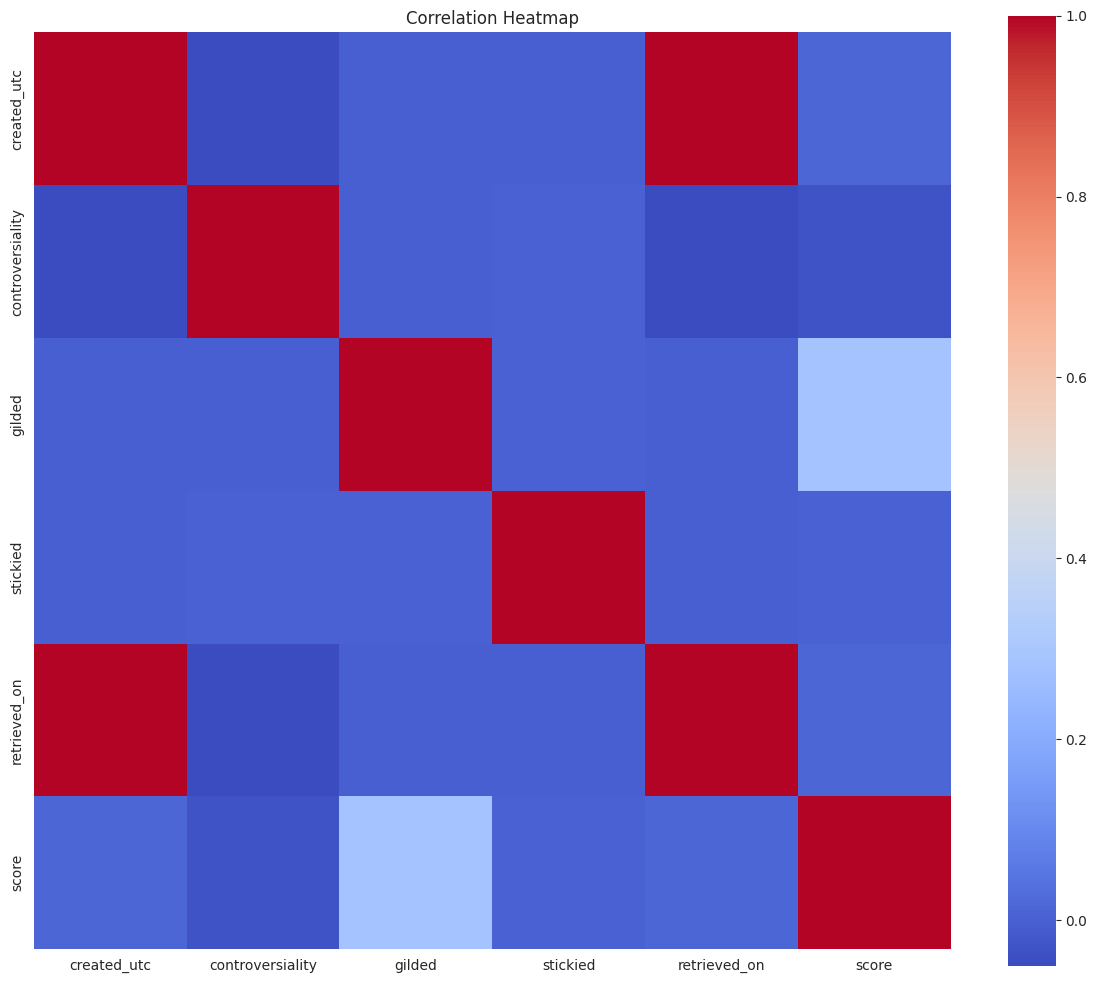


Highly Correlated Pairs (>|0.90|):


,var1,var2,correlation
3,created_utc,retrieved_on,0.997101


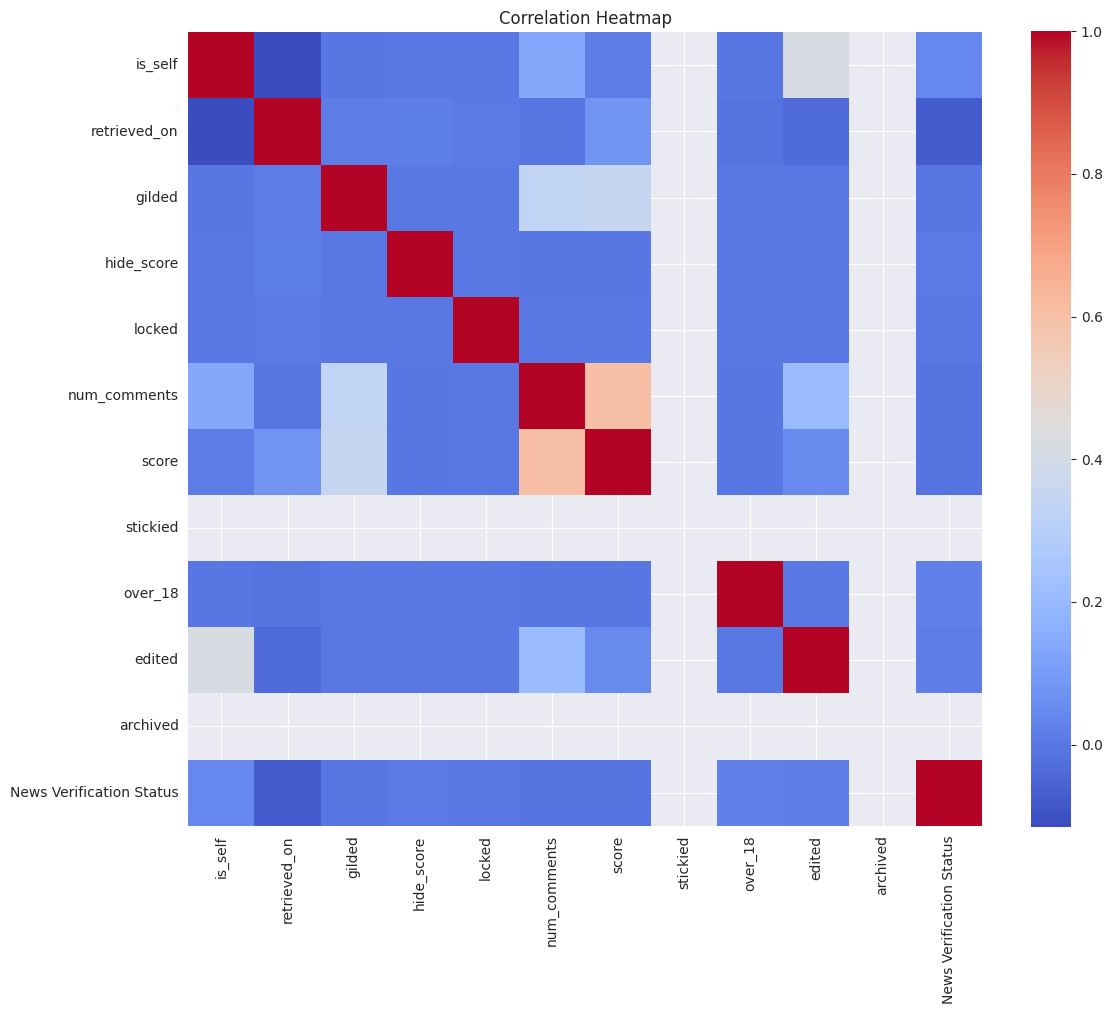


Highly Correlated Pairs (>|0.90|):


,var1,var2,correlation


In [11]:
def flatten_nested_columns(df):
    nested_cols = []
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (dict, list))).any():
            nested_cols.append(col)

    for col in nested_cols:
        try:
            flattened = json_normalize(df[col].dropna(), sep='.', errors='ignore')
            flattened.columns = [f"{col}.{subcol}" for subcol in flattened.columns]
            df = df.drop(columns=[col]).reset_index(drop=True)
            df = pd.concat([df, flattened.reset_index(drop=True)], axis=1)
        except Exception as e:
            print(f"Could not flatten column '{col}': {e}")

    return df


def analyze_missingness(df, threshold=0.99):
    missing_ratio = df.isnull().mean()
    unary_ratio = df.nunique(dropna=False) / len(df)

    missing_df = pd.DataFrame({
        'column': missing_ratio.index,
        'missing_percent': (missing_ratio * 100).round(2)
    }).sort_values(by='missing_percent', ascending=False)

    unary_df = pd.DataFrame({
        'column': unary_ratio.index,
        'unary_percent': (1 - unary_ratio).round(4) * 100
    }).sort_values(by='unary_percent', ascending=False)

    print("\nMissingness Summary:")
    display(missing_df[missing_df['missing_percent'] >= (threshold * 100)])

    print("\nUnary Columns Summary:")
    display(unary_df[unary_df['unary_percent'] >= 99.0])

    to_drop = missing_df[missing_df['missing_percent'] >= (threshold * 100)]['column'].tolist()
    unary_cols = unary_df[unary_df['unary_percent'] >= 99.0]['column'].tolist()

    return to_drop, unary_cols


def show_correlation_heatmap(df, threshold=0.9):

    import seaborn as sns

    numeric_df = df.select_dtypes(include=[np.number]).dropna(axis=1, how='any')
    corr_matrix = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', square=True)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # Identify highly correlated pairs
    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .rename(columns={0: 'correlation', 'level_0': 'var1', 'level_1': 'var2'})
    )
    high_corr = corr_pairs[corr_pairs['correlation'].abs() > threshold]

    print("\nHighly Correlated Pairs (>|{:.2f}|):".format(threshold))
    display(high_corr.sort_values(by='correlation', key=np.abs, ascending=False))

    return high_corr


def convert_boolean_to_int(df):
    bool_cols = df.select_dtypes(include=[bool]).columns
    df[bool_cols] = df[bool_cols].astype(int)
    return df


# 1. Flatten nested structures
df_comments = flatten_nested_columns(df_comments)
df_submission = flatten_nested_columns(df_submission)

# 2. Convert booleans to integers
df_comments = convert_boolean_to_int(df_comments)
df_submission = convert_boolean_to_int(df_submission)

# 3. Analyze missingness and unary values
print('For the comments table: ')
comm_to_drop, comm_unary_col = analyze_missingness(df_comments)

print('\nFor the submission table: ')
sub_to_drop, sub_unary_col = analyze_missingness(df_submission)

# 4. Visualize and examine numeric correlation
comm_corr = show_correlation_heatmap(df_comments)
sub_corr = show_correlation_heatmap(df_submission)

*******
## 3. Data Procesing and Feature Engineering
*******


In [12]:
df_comments_1 = df_comments.copy()
df_submission_1 = df_submission.copy()

df_submission_1.to_csv('submission_1.csv', index=False)

### 3.1 Submissions Level Features

Here, we safely convert date/time series and to enrich a submissions DataFrame by extracting text features using TF-IDF and PCA, performing sentiment analysis, and engineering additional attributes (like video detection and edited flags) while removing irrelevant columns. We aggregate user-level features from the submissions DataFrame by grouping entries by the author, calculating mean values for continuous variables (like comment count, score, sentiment, and PCA components) and the maximum for binary flags. The aggregated user features are then merged back into the original DataFrame, with redundant columns removed for a cleaner dataset.

In [13]:

def safe_datetime_conversion(series):
    if np.issubdtype(series.dtype, np.datetime64):
        return series
    try:
        return pd.to_datetime(series, errors='raise')
    except Exception:
        return pd.to_datetime(series, unit='s', errors='coerce')


def enrich_submission_features(df, comments_df):

    #REMOVED FOR LEAKAGE

    # TFIDF + PCA on title/original_title
    text_data = df[['title', 'original_title']].fillna('').agg(' '.join, axis=1)
    tfidf = TfidfVectorizer(max_features=500)
    tfidf_matrix = tfidf.fit_transform(text_data)
    pca = PCA(n_components=10)
    tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
    for i in range(tfidf_pca.shape[1]):
        df[f's_text_pca_{i}'] = tfidf_pca[:, i]

    # Sentiment analysis
    sia = SentimentIntensityAnalyzer()
    df['s_sentiment'] = df['title'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])


    # Drop title
    df = df.drop(columns=['title'])

    # Prefix selected columns
    keep_cols = ['num_comments', 'score', 'controversiality', 'gilded',
                 'stickied', 'archived', 'no_follow', 'score_hidden', 'author_cakeday', 'locked', 'hide_score', 'quarantine', 'saved', 'is_self']
    for col in keep_cols:
        if col in df.columns:
            df[f's_{col}'] = df[col]

    # Time to first comment
    if 'name' in df.columns and 'created_utc' in df.columns:
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
        comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'], unit='s', errors='coerce')
        name_to_time = comments_df.groupby('link_id')['created_utc'].min()
        df['s_time_to_first_comment'] = df['name'].map(name_to_time) - df['created_utc']


    # Mark edited submissions
    if 'edited' in df.columns:
        df['s_edited'] = df['edited'].apply(lambda x: 1 if x != 0 else 0)

    # Detect video from thumbnail and secure_media
    df['s_video'] = 0
    if 'thumbnail' in df.columns:
        df['s_video'] = df['thumbnail'].fillna('').apply(lambda x: 1 if 'media' in x else 0)
    if 'secure_media' in df.columns:
        df['s_video'] = df.apply(
            lambda row: 1 if row['secure_media'] == 'youtube.com' else row['s_video'], axis=1
        )

    # Drop irrelevant or verbose columns
    drop_cols = [
        'secure_media', 'thumbnail', 'permalink', 'from_kind', 'url', 'media_embed', 'distinguished', 'from',
        'link_flair', 'preview', 'subreddit', 'downs', 'ups', 'media', 'from_id', 'author_flair_text',
        'domain', 'selftext', 'subreddit', 'link_flair_css_class', 'suggested_sort', 'brand_safe', 'hidden',
        'view_count', 'thumbnail_height', 'thumbnail_width', 'is_video', 'approved_at_utc', 'banned_at_utc',
        'can_mod_post', 'is_crosspostable', 'num_crossposts', 'parent_whitelist_status', 'whitelist_status',
        'is_reddit_media_domain', 'pinned', 'subreddit_type', 'crosspost_parent', 'mod_note', 'mod_reason_by', 'mod_reason_title', 'post_hint', 'secure_media_embed', 'link_flair_text', 'subreddit_id', 'contest_mode', 'spoiler', 'crosspost_parent_list'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    return df

df_submission_2 = enrich_submission_features(df_submission_1, df_comments_1)
df_submission_2.to_csv('submission_2.csv', index=False)


In [14]:
df_submission_2.head()

,is_self,quarantine,retrieved_on,author_flair_css_class,gilded,hide_score,locked,id,name,num_comments,saved,score,created_utc,stickied,author,over_18,edited,archived,author_cakeday,can_gild,original_title,News Verification Status,s_text_pca_0,s_text_pca_1,s_text_pca_2,s_text_pca_3,s_text_pca_4,s_text_pca_5,s_text_pca_6,s_text_pca_7,s_text_pca_8,s_text_pca_9,s_sentiment,s_num_comments,s_score,s_gilded,s_stickied,s_archived,s_author_cakeday,s_locked,s_hide_score,s_quarantine,s_saved,s_is_self,s_time_to_first_comment,s_edited,s_video
1,0,0.0,1455036927,None,0,0,0,430j3i,t3_430j3i,1,0.0,1,NaT,0,mohamud77,0,0,0,NaN,NaN,THIS VIDEO WILL MAKE YOU VOTE FOR BERNIE SANDERS,1,-0.038160,-0.175002,-0.050983,-0.023337,-0.160181,-0.033303,0.138150,-0.054160,0.315996,-0.021954,0.0000,1,1,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0
2,0,0.0,1455045000,None,0,0,0,43hj50,t3_43hj50,4,0.0,0,NaT,0,pnw_diver,0,0,0,NaN,NaN,Hillary Clinton's Iraq War Albatross,0,-0.044484,-0.287455,-0.286486,0.431122,0.064116,0.014355,-0.046436,0.038992,-0.192083,-0.002288,-0.5994,4,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1
3,0,0.0,1455017732,None,0,0,0,41w54m,t3_41w54m,12,0.0,13,NaT,0,unity100,0,0,0,NaN,NaN,Socialism!!!,1,-0.043724,-0.066372,-0.008177,-0.064559,-0.038906,0.024677,-0.022821,-0.032170,-0.036775,-0.022237,0.0000,12,13,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0
4,0,0.0,1454994814,None,0,0,0,40k01i,t3_40k01i,0,0.0,3,NaT,0,TwoGee,0,0,0,NaN,NaN,The House Freedom Caucus is considering hiring...,0,0.242029,0.026545,0.218611,0.077202,-0.023352,-0.164901,-0.014257,-0.041149,-0.046465,0.069433,0.6369,0,3,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1
5,0,0.0,1454980955,None,0,0,0,3zqmd5,t3_3zqmd5,1,0.0,0,NaT,0,geargirl,0,0,0,NaN,NaN,"Purity, Disgust and Donald Trump",1,-0.121823,0.539519,-0.218277,0.176871,-0.023117,-0.056712,-0.078594,-0.058122,0.230474,-0.400822,-0.5994,1,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1


### 3.2 Add User Aggregated Features from Submissions

Here we aggregate user features from submission to add additional features to our user node feature set. We then drop any text we believe is likely to leak our label, including the PCA reduced text vectors and the sentiment of the source.

In [15]:
df_submission_3 = df_submission_2.copy()

In [16]:
def enrich_user_features(df):
    if 'author' not in df.columns:
        return df

    user_groups = df.groupby('author')

    agg_dict = {
        'num_comments': 'mean',
        'score': 'mean',
        's_sentiment': 'mean'
    }

    for i in range(10):
        agg_dict[f's_text_pca_{i}'] = 'mean'

    user_feats = user_groups.agg(agg_dict)

    user_feats['u_num_comments'] = user_feats['num_comments']
    user_feats['u_score'] = user_feats['score']

    for i in range(10):
        user_feats[f'u_text_pca_{i}'] = user_feats[f's_text_pca_{i}']

    for binary_col in ['locked', 'saved', 'stickied', 's_gilded']:
        if binary_col in df.columns:
            user_feats[f'u_{binary_col}'] = user_groups[binary_col].max()

    df = df.merge(user_feats[[col for col in user_feats.columns if col.startswith('u_')]], on='author', how='left')


    df.drop(columns = ['is_self', 'quarantine', 'retrieved_on', 'gilded', 'hide_score', 'locked', 'created_utc', 'over_18', 'edited', 'archived', 'author_cakeday', 'can_gild', 'original_title', 'author_flair_css_class', 's_text_pca_0', 's_text_pca_1', 's_text_pca_2', 's_text_pca_3', 's_text_pca_4', 's_text_pca_5', 's_text_pca_6', 's_text_pca_7', 's_text_pca_8', 's_text_pca_9', 's_sentiment'], inplace=True)

    return df


df_submission_3 = enrich_user_features(df_submission_3)
display(df_submission_3)

,id,name,num_comments,saved,score,stickied,author,News Verification Status,s_num_comments,s_score,s_gilded,s_stickied,s_archived,s_author_cakeday,s_locked,s_hide_score,s_quarantine,s_saved,s_is_self,s_time_to_first_comment,s_edited,s_video,u_num_comments,u_score,u_text_pca_0,u_text_pca_1,u_text_pca_2,u_text_pca_3,u_text_pca_4,u_text_pca_5,u_text_pca_6,u_text_pca_7,u_text_pca_8,u_text_pca_9,u_locked,u_saved,u_stickied,u_s_gilded
0,430j3i,t3_430j3i,1,0.0,1,0,mohamud77,1,1,1,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0,1.000000,1.00000,-0.038160,-0.175002,-0.050983,-0.023337,-0.160181,-0.033303,0.138150,-0.054160,0.315996,-0.021954,0,0.0,0,0
1,43hj50,t3_43hj50,4,0.0,0,0,pnw_diver,0,4,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,9.000000,20.50000,0.035712,-0.298321,-0.372741,0.403863,0.320307,0.016274,0.003062,0.029903,-0.147932,0.074134,0,0.0,0,0
2,41w54m,t3_41w54m,12,0.0,13,0,unity100,1,12,13,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0,12.000000,13.00000,-0.043724,-0.066372,-0.008177,-0.064559,-0.038906,0.024677,-0.022821,-0.032170,-0.036775,-0.022237,0,0.0,0,0
3,40k01i,t3_40k01i,0,0.0,3,0,TwoGee,0,0,3,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,63.000000,334.02381,0.028580,-0.004503,0.007451,0.015385,-0.037954,-0.013789,0.010425,0.017300,0.000579,0.010241,0,0.0,0,0
4,3zqmd5,t3_3zqmd5,1,0.0,0,0,geargirl,1,1,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,26.000000,1.00000,0.013499,0.241925,-0.116117,0.042472,-0.002485,-0.107738,-0.053343,-0.030566,0.128639,-0.264941,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,7kvr0t,t3_7kvr0t,4,NaN,7,0,PhenomeNarc,0,4,7,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,0,4.000000,7.00000,-0.069862,-0.111665,0.026724,-0.115191,-0.104237,0.033622,0.166674,0.056732,-0.088595,-0.016815,0,NaN,0,0
20846,7gw6uw,t3_7gw6uw,5,NaN,81,0,OtulGib,0,5,81,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,0,5.000000,81.00000,-0.044289,0.131446,-0.067163,-0.074224,0.056867,-0.103531,-0.029703,0.004658,-0.044337,-0.035126,0,NaN,0,0
20847,7j4wpv,t3_7j4wpv,18,NaN,37,0,cyanocobalamin,1,18,37,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,1,12.666667,16.00000,-0.031350,0.032901,0.015780,-0.034488,0.012700,-0.068373,-0.048961,0.017521,0.003109,0.065276,0,0.0,0,0
20848,7kyicu,t3_7kyicu,38,NaN,352,0,GOPniks,0,38,352,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,1,15.600000,148.60000,0.004719,-0.044820,0.016534,-0.061741,-0.014067,0.035410,-0.017767,-0.032813,-0.045427,-0.019303,0,NaN,0,0


### 3.3 Comments Level Features

We continue to extract information related to comments by extracting text features from the comment body using TF-IDF and PCA, computing sentiment scores with VADER, and marking edited comments. Similarly to submission, we then aggregates these metrics to derive user-level features, merges them back into the DataFrame.

In [17]:
df_comments_2 = df_comments_1.copy()

In [18]:
def enrich_user_features_from_comments(df):


    # TFIDF on comment body
    tfidf = TfidfVectorizer(max_features=300)
    tfidf_matrix = tfidf.fit_transform(df['body'].fillna(''))

    # Reduce TFIDF to 10 components via PCA
    pca = PCA(n_components=10)
    tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())
    tfidf_df = pd.DataFrame(tfidf_pca, columns=[f'u_body_pca_{i}_c' for i in range(tfidf_pca.shape[1])])
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

    # Sentiment
    sia = SentimentIntensityAnalyzer()
    df['u_sentiment_c'] = df['body'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

    # Mark edited submissions
    if 'edited' in df.columns:
        df['c_edited'] = df['edited'].apply(lambda x: 1 if x != 0 else 0)


    # Sentiment received from replies (average per recipient)
    if 'name' in df.columns and 'parent_id' in df.columns and 'author' in df.columns:
        name_author_map = df.set_index('name')['author']
        sentiment_reply_df = df[['parent_id', 'u_sentiment_c']].copy()
        sentiment_reply_df['recipient'] = sentiment_reply_df['parent_id'].map(name_author_map)
        avg_sentiment_received = sentiment_reply_df.groupby('recipient')['u_sentiment_c'].mean().rename('u_avg_sentiment_received_c')
        df = df.merge(avg_sentiment_received, how='left', left_on='author', right_index=True)

        # Time to first reply per comment
        df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')
        reply_times = df.groupby('parent_id')['created_utc'].min()
        df['c_time_to_first_reply'] = df['name'].map(reply_times) - df['created_utc']
        df['c_time_to_first_reply'] = df['c_time_to_first_reply'].dt.total_seconds()

        # Aggregate average time to first reply per user
        avg_time_reply = df.groupby('author')['c_time_to_first_reply'].mean().rename('u_avg_time_to_reply_c')
        df = df.merge(avg_time_reply, on='author', how='left')

    # Aggregate user-level features
    user_groups = df.groupby('author')
    user_feats = user_groups.agg({
        'score': 'mean',
        'controversiality': 'mean',
        'u_sentiment_c': 'mean'
    })
    user_feats['u_avg_score_c'] = user_feats['score']
    user_feats['u_avg_controversiality_c'] = user_feats['controversiality']
    user_feats['u_avg_sentiment_c'] = user_feats['u_sentiment_c']

    # Binary features
    for col in ['stickied', 'gilded']:
        if col in df.columns:
            user_feats[f'u_{col}_c'] = user_groups[col].max()

    df = df.merge(user_feats[[col for col in user_feats.columns if col.startswith('u_')]], on='author', how='left')
    df = df.drop(columns=['ups', 'downs'], errors='ignore')

    # Drop specified columns
    drop_cols = [
        'subreddit_id', 'subreddit', 'author_flair_text', 'subreddit_type', 'permalink',
        'author_flair_template_id', 'can_mod_post', 'score_hidden', 'is_submitter'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # Export first 1000 rows
    df.head(1000).to_csv("comment_user_features_sample.csv", index=False)

    return df

df_comments_2 = enrich_user_features_from_comments(df_comments_2)




### 3.4 Interaction Level Features

Here we pull out interaction level features, these features we will be used as edge attributes in our GNN. These include common elements of a reply or comment on reddit, the PCA reduced vector of the text, the sentiment, score, controversiality, etc. These features we believe represent the semantic and predictive information that can help us infer fake news correctly. Some thought had been made to add additional features related to time to reply, similarity of reply to parent, sentiment differences, depth (the extent that the reply carries valuable information), and others but we opted for a simpler approach for this context.

In [19]:
def enrich_comment_level_features(df):
    # Rename PCA columns for comment-level usage
    for i in range(10):
        if f'u_body_pca_{i}_c' in df.columns:
            df[f'c_body_pca_{i}'] = df[f'u_body_pca_{i}_c']

    # Comment-level sentiment
    if 'u_sentiment_c_x' in df.columns:
        df['c_sentiment'] = df['u_sentiment_c_x']

    # Score and controversiality
    for col in ['score', 'controversiality']:
        if col in df.columns:
            df[f'c_{col}'] = df[col]

    # Binary flags
    for flag in ['stickied', 'gilded', 'edited']:
        if flag in df.columns:
            df[f'c_{flag}'] = df[flag].astype(int)


    return df


df_comments_2 = enrich_comment_level_features(df_comments_2)

### 3.4.1 Additional edge level features


In [20]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import entropy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


def compute_c_sentiment_disagreement(df):
    sia = SentimentIntensityAnalyzer()
    df['c_sentiment'] = df['body'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

    parent_sentiment_map = df.set_index('name')['c_sentiment']
    df['c_parent_sentiment'] = df['parent_id'].map(parent_sentiment_map)
    df['c_sentiment_disagreement'] = (df['c_sentiment'] - df['c_parent_sentiment']).abs()

    return df


def compute_c_reply_similarity(df):
    tfidf = TfidfVectorizer(max_features=100)
    tfidf_matrix = tfidf.fit_transform(df['body'].fillna(''))

    parent_body_map = df.set_index('name')['body'].fillna('')
    df['c_parent_body'] = df['parent_id'].map(parent_body_map)

    def cosine_sim(row):
        if pd.isnull(row['c_parent_body']) or row['c_parent_body'].strip() == '':
            return np.nan
        v1 = tfidf.transform([row['body']])
        v2 = tfidf.transform([row['c_parent_body']])
        return cosine_similarity(v1, v2)[0][0]

    df['c_reply_similarity'] = df.apply(cosine_sim, axis=1)
    return df



df_comments_2 = compute_c_sentiment_disagreement(df_comments_2)
df_comments_2 = compute_c_reply_similarity(df_comments_2)





In [21]:
df_submission_3.drop(columns = ['id', 'num_comments', 'saved', 'score', 'stickied'], inplace=True)
df_comments_2.drop(columns = ['stickied', 'created_utc', 'gilded', 'distinguished', 'edited', 'controversiality', 'author_flair_css_class', 'score', 'removal_reason', 'archived', 'send_replies', 'can_gild', 'no_follow', 'body', 'id', 'u_sentiment_c_y', 'u_sentiment_c_x'], inplace=True)

In [22]:
display(df_submission_3)
display(df_comments_2)

,name,author,News Verification Status,s_num_comments,s_score,s_gilded,s_stickied,s_archived,s_author_cakeday,s_locked,s_hide_score,s_quarantine,s_saved,s_is_self,s_time_to_first_comment,s_edited,s_video,u_num_comments,u_score,u_text_pca_0,u_text_pca_1,u_text_pca_2,u_text_pca_3,u_text_pca_4,u_text_pca_5,u_text_pca_6,u_text_pca_7,u_text_pca_8,u_text_pca_9,u_locked,u_saved,u_stickied,u_s_gilded
0,t3_430j3i,mohamud77,1,1,1,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0,1.000000,1.00000,-0.038160,-0.175002,-0.050983,-0.023337,-0.160181,-0.033303,0.138150,-0.054160,0.315996,-0.021954,0,0.0,0,0
1,t3_43hj50,pnw_diver,0,4,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,9.000000,20.50000,0.035712,-0.298321,-0.372741,0.403863,0.320307,0.016274,0.003062,0.029903,-0.147932,0.074134,0,0.0,0,0
2,t3_41w54m,unity100,1,12,13,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,0,12.000000,13.00000,-0.043724,-0.066372,-0.008177,-0.064559,-0.038906,0.024677,-0.022821,-0.032170,-0.036775,-0.022237,0,0.0,0,0
3,t3_40k01i,TwoGee,0,0,3,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,63.000000,334.02381,0.028580,-0.004503,0.007451,0.015385,-0.037954,-0.013789,0.010425,0.017300,0.000579,0.010241,0,0.0,0,0
4,t3_3zqmd5,geargirl,1,1,0,0,0,0,NaN,0,0,0.0,0.0,0,NaT,0,1,26.000000,1.00000,0.013499,0.241925,-0.116117,0.042472,-0.002485,-0.107738,-0.053343,-0.030566,0.128639,-0.264941,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,t3_7kvr0t,PhenomeNarc,0,4,7,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,0,4.000000,7.00000,-0.069862,-0.111665,0.026724,-0.115191,-0.104237,0.033622,0.166674,0.056732,-0.088595,-0.016815,0,NaN,0,0
20846,t3_7gw6uw,OtulGib,0,5,81,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,0,5.000000,81.00000,-0.044289,0.131446,-0.067163,-0.074224,0.056867,-0.103531,-0.029703,0.004658,-0.044337,-0.035126,0,NaN,0,0
20847,t3_7j4wpv,cyanocobalamin,1,18,37,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,1,12.666667,16.00000,-0.031350,0.032901,0.015780,-0.034488,0.012700,-0.068373,-0.048961,0.017521,0.003109,0.065276,0,0.0,0,0
20848,t3_7kyicu,GOPniks,0,38,352,0,0,0,NaN,0,0,NaN,NaN,0,NaT,0,1,15.600000,148.60000,0.004719,-0.044820,0.016534,-0.061741,-0.014067,0.035410,-0.017767,-0.032813,-0.045427,-0.019303,0,NaN,0,0


,link_id,author,retrieved_on,parent_id,name,u_body_pca_0_c,u_body_pca_1_c,u_body_pca_2_c,u_body_pca_3_c,u_body_pca_4_c,u_body_pca_5_c,u_body_pca_6_c,u_body_pca_7_c,u_body_pca_8_c,u_body_pca_9_c,c_edited,u_avg_sentiment_received_c,c_time_to_first_reply,u_avg_time_to_reply_c,u_avg_score_c,u_avg_controversiality_c,u_avg_sentiment_c,u_stickied_c,u_gilded_c,c_body_pca_0,c_body_pca_1,c_body_pca_2,c_body_pca_3,c_body_pca_4,c_body_pca_5,c_body_pca_6,c_body_pca_7,c_body_pca_8,c_body_pca_9,c_sentiment,c_score,c_controversiality,c_stickied,c_gilded,c_parent_sentiment,c_sentiment_disagreement,c_parent_body,c_reply_similarity
0,t3_3yzf1w,GrindhouseMedia,1454210811,t3_3yzf1w,t1_cyhzovj,-0.051245,0.011651,0.141907,-0.069129,0.133125,-0.059792,-0.030807,-0.101826,-0.032168,0.013703,0,0.101150,1134.0,6686.500000,3.500000,0.000000,-0.058500,0,0,-0.051245,0.011651,0.141907,-0.069129,0.133125,-0.059792,-0.030807,-0.101826,-0.032168,0.013703,-0.5574,2,0,0,0,NaN,NaN,NaN,NaN
1,t3_3yzf1w,OnlyFactsMatter,1454210820,t3_3yzf1w,t1_cyhzpn2,0.194572,-0.059845,-0.149011,-0.111792,-0.192222,-0.043117,-0.046194,-0.152619,-0.099223,-0.205450,0,-0.053615,NaN,2736.310606,-2.463415,0.097561,-0.204834,0,0,0.194572,-0.059845,-0.149011,-0.111792,-0.192222,-0.043117,-0.046194,-0.152619,-0.099223,-0.205450,0.0904,1,1,0,0,NaN,NaN,NaN,NaN
2,t3_3yzf1w,CarsonOrSanders,1454210849,t3_3yzf1w,t1_cyhzrum,0.274452,-0.083835,0.013414,-0.033255,-0.047500,-0.151243,-0.065274,0.011814,-0.020479,0.056380,0,0.035445,492.0,2018.475309,-0.837004,0.171806,0.004989,0,0,0.274452,-0.083835,0.013414,-0.033255,-0.047500,-0.151243,-0.065274,0.011814,-0.020479,0.056380,-0.7680,10,0,0,0,NaN,NaN,NaN,NaN
3,t3_3yzf1w,tenparsecs,1454210946,t3_3yzf1w,t1_cyhzz91,0.061194,-0.098888,0.133179,-0.036699,-0.070478,0.224936,0.109649,-0.088408,-0.099672,0.070605,0,-0.116883,NaN,6515.259259,3.181034,0.146552,-0.099515,0,0,0.061194,-0.098888,0.133179,-0.036699,-0.070478,0.224936,0.109649,-0.088408,-0.099672,0.070605,0.0000,2,0,0,0,NaN,NaN,NaN,NaN
4,t3_3yzf1w,tenparsecs,1454210949,t1_cyhzrum,t1_cyhzzgy,0.011272,-0.122671,0.217984,-0.056007,0.096589,-0.041109,0.004623,-0.103318,-0.044644,0.043943,0,-0.116883,1916.0,6515.259259,3.181034,0.146552,-0.099515,0,0,0.011272,-0.122671,0.217984,-0.056007,0.096589,-0.041109,0.004623,-0.103318,-0.044644,0.043943,-0.9397,6,0,0,0,-0.7680,0.1717,&gt;She will continue to use the powers availa...,0.372727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658336,t3_5i6p4t,astrometrics,1491758424,t1_db6bi53,t1_dfd44hf,-0.076443,0.031728,0.113611,0.192129,-0.186721,0.137472,0.209366,-0.061046,-0.082495,-0.014074,0,NaN,NaN,NaN,1.000000,0.000000,-0.128000,0,0,-0.076443,0.031728,0.113611,0.192129,-0.186721,0.137472,0.209366,-0.061046,-0.082495,-0.014074,-0.1280,1,0,0,0,0.3612,0.4892,Sort of like how SJW is just a pejorative for ...,0.100629
658337,t3_5eq1x7,ewolf20,1491879252,t3_5eq1x7,t1_dfk07m9,-0.080241,-0.084596,0.146973,-0.091554,0.012099,-0.028437,-0.057604,-0.013754,0.120050,-0.048576,0,NaN,NaN,NaN,1.000000,0.000000,0.000000,0,0,-0.080241,-0.084596,0.146973,-0.091554,0.012099,-0.028437,-0.057604,-0.013754,0.120050,-0.048576,0.0000,1,0,0,0,NaN,NaN,NaN,NaN
658338,t3_5hkfuh,GammaLlama,1496477258,t3_5hkfuh,t1_dhhdhdh,0.020554,-0.006991,-0.034592,0.073010,0.066310,0.005546,-0.167757,-0.090386,0.000366,-0.121107,0,NaN,NaN,NaN,1.000000,0.000000,0.000000,0,0,0.020554,-0.006991,-0.034592,0.073010,0.066310,0.005546,-0.167757,-0.090386,0.000366,-0.121107,0.0000,1,0,0,0,NaN,NaN,NaN,NaN
658339,t3_5i6p4t,DashPundit,1496906982,t1_db6cb6a,t1_di642gs,0.317445,0.066295,0.014847,0.047938,-0.153329,0.010607,0.065102,-0.126325,-0.057147,0.085901,0,NaN,NaN,NaN,1.000000,0.000000,-0.968800,0,0,0.317445,0.066295,0.014847,0.047938,-0.153329,0.010607,0.065102,-0.126325,-0.057147,0.085901,-0.9620,1,0,0,0,-0.4371,0.5249,SJW is a pejorative term for anyone who traffi...,0.294864


In [23]:
print(df_submission_3['name'].isna().sum())
df_comments_2.drop(columns = ['c_parent_body'], inplace=True)

0


In [24]:
df_submission_3.drop(columns = ['s_time_to_first_comment'], inplace=True)

In [25]:
user_features_2 = user_features.drop(columns = ['verification_status_0', 'author', 'verification_status_1', 'verified_news_score', 'verified_news_level', 'comment_count'])
# Replace NaNs in c_time_to_first_reply
max_c_time = df_comments_2['c_time_to_first_reply'].max(skipna=True)
df_comments_2['c_time_to_first_reply'].fillna(max_c_time, inplace=True)

# Replace NaNs in u_avg_time_to_reply_c
max_u_time = df_comments_2['u_avg_time_to_reply_c'].max(skipna=True)
df_comments_2['u_avg_time_to_reply_c'].fillna(max_u_time, inplace=True)

In [26]:
def report_missing_percent(df, name):
    print(f"\n📊 Percent missing in {name}:")
    total = len(df)
    missing_percent = (df.isna().sum() / total * 100).sort_values(ascending=False)
    missing_percent = missing_percent[missing_percent > 0]

    if not missing_percent.empty:
        print(missing_percent.round(2).astype(str) + '%')
    else:
        print("No missing values.")

# Run diagnostics
report_missing_percent(user_features, "user_features")
report_missing_percent(df_comments_2, "df_comments_2")
report_missing_percent(df_submission_3, "df_submissions_3")


📊 Percent missing in user_features:
verification_status_1    89.83%
verification_status_0    89.83%
author                   89.83%
dtype: object

📊 Percent missing in df_comments_2:
c_reply_similarity            22.27%
c_sentiment_disagreement      22.27%
c_parent_sentiment            22.27%
u_avg_sentiment_received_c      7.4%
dtype: object

📊 Percent missing in df_submissions_3:
s_author_cakeday    99.88%
s_saved             50.29%
u_saved             36.75%
s_quarantine        20.87%
dtype: object


In [27]:
df_submission_3.drop(columns = 's_author_cakeday', inplace=True)

for col in ['c_reply_similarity', 'c_sentiment_disagreement', 'c_parent_sentiment']:
    if col in df_comments_2.columns:
        mean_val = df_comments_2[col].mean(skipna=True)
        df_comments_2[col].fillna(mean_val, inplace=True)

if 'u_avg_sentiment_received_c' in df_comments_2.columns:
    mean_val = df_comments_2['u_avg_sentiment_received_c'].mean(skipna=True)
    df_comments_2['u_avg_sentiment_received_c'].fillna(mean_val, inplace=True)

for col in ['s_saved', 'u_saved', 's_quarantine']:
    if col in df_submission_3.columns:
        median_val = df_submission_3[col].median(skipna=True)
        df_submission_3[col].fillna(median_val, inplace=True)


df_submission_3[['s_saved', 'u_saved', 's_quarantine']] = df_submission_3[['s_saved', 'u_saved', 's_quarantine']].astype(int)



********
## 4. Graph Creation
********

### 4.1 Directed Graph

This function constructs a directed graph that models the interactions between users and news sources (submissions) within the dataset. It combines user-level features derived from both comments and submissions to create rich node representations. These features include behavioral metrics (e.g., comment frequency, sentiment scores) and content attributes (e.g., TF-IDF PCA components), which are essential for downstream analysis with graph neural networks (GNNs) aimed at detecting fake news.

**Graph Structure and Logic:**

- **Nodes:**
  - **User Nodes:**
    All unique users are added as nodes, with their attributes aggregated from three sources:
    1. A precomputed user features DataFrame.
    2. User-level attributes derived from comments.
    3. User-level attributes derived from submissions.
  - **Source Nodes:**
    Each submission (or source) is added as a node with its attributes (prefixed with 's_') such as news verification status and other metadata. This helps in distinguishing between user nodes and source nodes by assigning a `node_type` attribute.

- **Edges:**
  - **Reply and Interaction Edges:**
    The graph captures two main types of user interactions:
    1. **User-to-User Replies:**
       When a comment is a reply to another comment (identified by a parent ID starting with 't1_'), an edge is added from the parent comment's author to the replying user.
    2. **Userto-Submission Interactions:**
       When a comment replies directly to a submission (parent ID starting with 't3_'), an edge from the commenting user to the source node is created.

- **Purpose for Fake News Detection:**
  - The constructed graph encapsulates the dynamics between users and content sources, which is crucial for modeling information propagation, user credibility, and content engagement patterns. When used as input for a GNN, this heterogeneous edge attentive graph can help in learning latent representations of users and sources, ultimately aiding in identifying suspicious or fake news through patterns in interaction behavior.
  - The different edge types and rich node features allow the GNN to differentiate between various forms of influence and communication within the network, potentially highlighting communities or individuals that are central to the spread of fake news.


In [28]:
def build_user_source_graph(df_comments, df_submissions, user_features):
    G = nx.DiGraph()

    # Precompute user attributes
    user_feature_dict = user_features.to_dict(orient='index')
    user_comment_attrs = df_comments[df_comments.columns[df_comments.columns.str.startswith('u_') | (df_comments.columns == 'author')]].drop_duplicates('author').set_index('author').to_dict(orient='index')
    user_submission_attrs = df_submissions[df_submissions.columns[df_submissions.columns.str.startswith('u_') | (df_submissions.columns == 'author')]].drop_duplicates('author').set_index('author').to_dict(orient='index')

    #set default values for user features
    all_user_keys = set()
    for d in [user_feature_dict, user_comment_attrs, user_submission_attrs]:
        for u in d.values():
            all_user_keys.update(u.keys())

    default_user_attrs = {k: 0.0 for k in all_user_keys}

    # Add user nodes
    all_users = pd.concat([df_comments['author'], df_submissions['author']]).dropna().unique()
    for user in tqdm(all_users, desc="Adding user nodes"):
        u_attrs = default_user_attrs.copy()  # start with default

        if user in user_feature_dict:
            u_attrs.update(user_feature_dict[user])
        if user in user_comment_attrs:
            u_attrs.update(user_comment_attrs[user])
        if user in user_submission_attrs:
            u_attrs.update(user_submission_attrs[user])

        G.add_node(user, node_type='user', **u_attrs)

    # Add source nodes (and embed poster info into source node itself)
    for row in tqdm(df_submissions.itertuples(index=False), total=len(df_submissions), desc="Adding source nodes"):
        source_id = row.name
        attrs = {col: getattr(row, col) for col in df_submissions.columns if col.startswith('s_')}

        # Add label (News_Verification_Status)
        status = getattr(row, 'News_Verification_Status', None)
        if status is None:
            try:
                status = df_submissions.loc[df_submissions['name'] == row.name, 'News Verification Status'].values[0]
            except IndexError:
                status = None
        attrs['News_Verification_Status'] = float(status) if status is not None else None

        # Add poster-derived features directly to source node
        if row.author in user_feature_dict:
            attrs['poster_influence'] = user_feature_dict[row.author].get('u_influence_score', 0.0)
            attrs['poster_karma'] = user_feature_dict[row.author].get('u_score', 0.0)

        G.add_node(source_id, node_type='source', **attrs)

    # Add reply + comment edges (only 'reply' and 'comment_to_source')
    comment_author_map = df_comments.set_index('name')['author'].to_dict()
    post_author_map = df_submissions.set_index('name')['author'].to_dict()
    comment_attr_map = df_comments.set_index('name')[df_comments.columns[df_comments.columns.str.startswith('c_')]].to_dict(orient='index')

    for row in tqdm(df_comments.itertuples(index=False), total=len(df_comments), desc="Adding reply edges"):
        child = row.author
        parent_id = row.parent_id
        source_id = row.link_id
        edge_attrs = comment_attr_map.get(row.name, {})

        if parent_id.startswith('t1_'):
            parent = comment_author_map.get(parent_id)
            if parent and parent != child:
                G.add_edge(parent, child, e_type='reply', **edge_attrs)

        elif parent_id.startswith('t3_'):
            if source_id in G:
                G.add_edge(child, source_id, e_type='comment_to_source', **edge_attrs)

    return G

g = build_user_source_graph(df_comments_2, df_submission_3, user_features_2)

Adding reply edges: 100%|██████████| 658341/658341 [00:02<00:00, 254363.19it/s]


In [29]:
print("Node types:", Counter(nx.get_node_attributes(g, 'node_type').values()))
print("Edge types:", Counter(nx.get_edge_attributes(g, 'e_type').values()))

Node types: Counter({'user': 104993, 'source': 20850})
Edge types: Counter({'reply': 398943, 'comment_to_source': 82314})


### 4.1.1 Graph Pruning

In this section we prune some irrelevant nodes from the graph. We first prune users with less than 3 total interactions, whether in-degree or out-degree. We then identify users who are not reachable from a source, these users will not provide us with relevant information to predicting a source as fake news. We then recreate our graph, thus pruning any isolated nodes that have no connections with other nodes. The goal of this section is to reduce the noise of irrelevant nodes and edges in our GNN.

In [30]:
from networkx.algorithms.traversal.breadth_first_search import bfs_tree

# Count user degrees
user_degrees = Counter()
for u, v, data in g.edges(data=True):
    if g.nodes[u]['node_type'] == 'user':
        user_degrees[u] += 1
    if g.nodes[v]['node_type'] == 'user':
        user_degrees[v] += 1

# Remove low-activity users
low_activity_users = {u for u, deg in user_degrees.items() if deg < 3}
g.remove_nodes_from(low_activity_users)

# Collect source nodes
source_nodes = [n for n, d in g.nodes(data=True) if d['node_type'] == 'source']

# Create one reverse view to avoid recomputing
g_rev = g.reverse(copy=False)

# Forward and reverse reachable nodes
reachable_users = set()

forward_reachable = set()
for n in nx.multi_source_dijkstra_path_length(g, source_nodes, cutoff=None).keys():
    forward_reachable.add(n)

backward_reachable = set()
for n in nx.multi_source_dijkstra_path_length(g.reverse(copy=False), source_nodes, cutoff=None).keys():
    backward_reachable.add(n)

reachable_users = forward_reachable | backward_reachable

# Identify and remove unreachable users
user_nodes = [n for n, d in g.nodes(data=True) if d['node_type'] == 'user']
pruned_users = [u for u in user_nodes if u not in reachable_users]
g.remove_nodes_from(pruned_users)

g = g.subgraph(g.nodes()).copy()
g.remove_nodes_from(list(nx.isolates(g)))


In [31]:
print(f"Total nodes: {g.number_of_nodes()}")
print(f"Total edges: {g.number_of_edges()}")

# Count remaining source and user nodes
source_count = sum(1 for _, d in g.nodes(data=True) if d['node_type'] == 'source')
user_count = sum(1 for _, d in g.nodes(data=True) if d['node_type'] == 'user')

print(f"Source nodes: {source_count}")
print(f"User nodes: {user_count}")

Total nodes: 57656
Total edges: 416539
Source nodes: 7295
User nodes: 50361


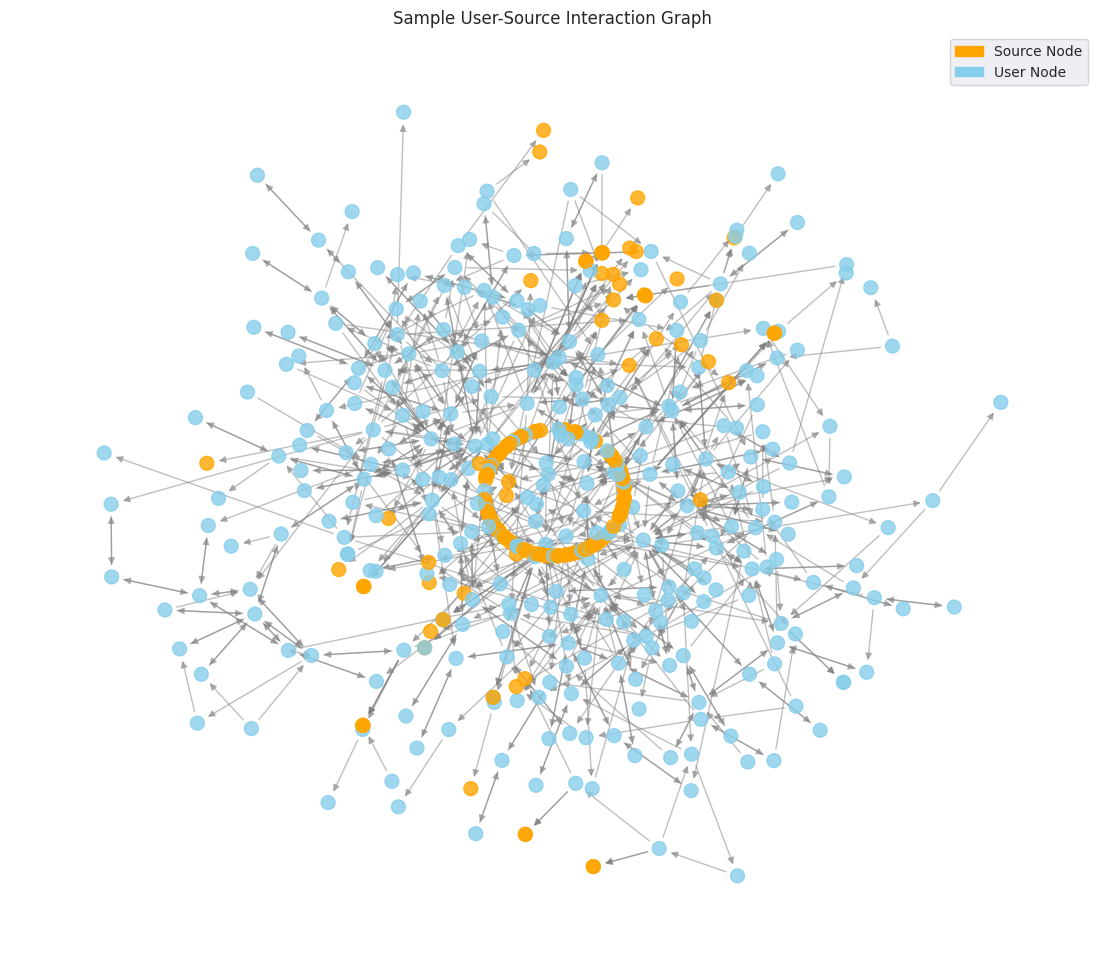

In [32]:
def visualize_graph(G, layout, sample_size=500):

    source_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'source']
    user_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'user']

    num_sources = min(len(source_nodes), sample_size // 3)
    num_users = sample_size - num_sources

    subgraph_nodes = source_nodes[:num_sources] + user_nodes[:num_users]
    H = G.subgraph(subgraph_nodes).copy()

    if layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(H)
    elif layout == 'circular':
        pos = nx.circular_layout(H)
    elif layout == 'shell':
        pos = nx.shell_layout(H)
    else:
        pos = nx.spring_layout(H, seed=42)

    node_colors = ['orange' if H.nodes[n].get('node_type') == 'source' else 'skyblue' for n in H.nodes()]

    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(H, pos, node_color=node_colors, node_size=100, alpha=0.8)
    nx.draw_networkx_edges(H, pos, edge_color='gray', alpha=0.5, arrows=True)

    legend_elements = [
        mpatches.Patch(color='orange', label='Source Node'),
        mpatches.Patch(color='skyblue', label='User Node')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Sample User-Source Interaction Graph")
    plt.axis('off')
    plt.show()

visualize_graph(g, 'kamada_kawai')

In [33]:
# Check a few source nodes for News_Verification_Status
sample_sources = [n for n, d in g.nodes(data=True) if d.get("node_type") == "source"]
missing_verifications = [n for n in sample_sources if "News_Verification_Status" not in g.nodes[n]]

print(f"Sources missing News Verification Status: {len(missing_verifications)} / {len(sample_sources)}")

status_vals = [g.nodes[n].get('News_Verification_Status') for n, d in g.nodes(data=True) if d.get("node_type") == "source"]
print("Missing values:", sum(pd.isna(status_vals)))
print("Example values:", pd.Series(status_vals).value_counts())

Sources missing News Verification Status: 0 / 7295
Missing values: 0
Example values: 1.0    3882
0.0    3413
Name: count, dtype: int64


In [34]:
missing_node_type = [n for n, attrs in g.nodes(data=True) if 'node_type' not in attrs]
print(f"❗ Nodes missing 'node_type': {len(missing_node_type)}")

❗ Nodes missing 'node_type': 0


### 4.2 DGL Heterograph

Next, we perform thge following diagnostics on the Constructed NetworkX Graph:
   - **Node Type Diagnostics:**
     It collects and prints counts of node types (e.g., 'user' and 'source') to verify that each node is properly labeled with a `node_type` attribute. Additionally, it prints sample attributes from both a user node and a source node, ensuring that the necessary features are present.
   - **Edge Type Diagnostics:**
     It gathers sample edges along with their `e_type` attribute (indicating interaction types like 'reply', or 'comment_to_source') and reports how many edges include this attribute. This check confirms that the interactions are correctly annotated, which is crucial for later analysis.

The, we convert to a DGL to incorporate desired features.
   - **Node Mapping and Feature Aggregation:**
     The function `convert_to_dgl_heterograph` converts the NetworkX graph into a DGL heterograph, which supports multiple node and edge types. It groups nodes by their `node_type` (e.g., users and sources) and collects their features. A mapping from the original node IDs to new integer IDs is created for each type.
   - **Edge Mapping:**
     Edges are processed by grouping them based on the source node type, the edge type (`e_type`), and the destination node type. The function constructs edge lists for each relation and converts these into tensors.
   - **Feature Attachment:**
     Both node and edge features are converted into tensors and attached to the corresponding nodes and edges in the heterograph. The code includes safeguards to handle missing or NaN values by replacing them with zeros, ensuring robust feature representations.


The resulting heterograph encapsulates different types of nodes (users and sources) and edges (e.g., replying), along with rich features derived during data engineering from both user behavior and content attributes. This multi-relational graph structure is ideal for GNNs, as it allows the model to learn specialized representations for each node type and to capture the nuanced interaction patterns between users and news sources. By leveraging this structured, feature-rich graph, a GNN can better detect patterns associated with fake news propagation. It can incorporate both the behavioral characteristics of users and the content-related metadata of sources to improve fake news detection performance.

In [35]:
from collections import Counter

# Node Type Diagnostics
node_types = [data.get("node_type") for _, data in g.nodes(data=True)]
print("Node type counts:", Counter(node_types))

# Check example node attributes
example_user = next((n for n, d in g.nodes(data=True) if d.get('node_type') == 'user'), None)
example_source = next((n for n, d in g.nodes(data=True) if d.get('node_type') == 'source'), None)
if example_user:
    print("User node features:", g.nodes[example_user])
if example_source:
    print("Source node features:", g.nodes[example_source])

# Edge Type Diagnostics
edges_with_types = [(u, v, d['e_type']) for u, v, d in g.edges(data=True) if 'e_type' in d]
print(f"Sample edges with e_type: {edges_with_types[:5]}")
print(f"Total edges with e_type: {len(edges_with_types)} / {g.number_of_edges()}")


Node type counts: Counter({'user': 50361, 'source': 7295})
User node features: {'node_type': 'user', 'u_body_pca_8_c': -0.03216823450694407, 'u_body_pca_3_c': -0.06912944965505442, 'u_ev_norm': 0.001483652481676103, 'u_avg_controversiality_c': 0.0, 'u_num_comments': 13.0, 'u_community_influence': 0.007134660993870043, 'u_community': 0, 'u_saved': 0, 'u_gilded_c': 0, 'u_locked': 0, 'u_betweenness_norm': 0.00026360169760363314, 'u_avg_time_to_reply_c': 6686.5, 'u_avg_sentiment_c': -0.058499999999999996, 'u_body_pca_7_c': -0.10182637598499972, 'u_avg_edge_weight': 1.0, 'u_text_pca_7': -0.016406893540059996, 'u_closeness': 0.10291416495097369, 'u_s_gilded': 0, 'u_text_pca_8': 0.03585447695746394, 'u_influence_score': 0.0014174507324057621, 'u_avg_sentiment_received_c': 0.10115, 'u_stickied_c': 0, 'u_in_degree_norm': 0.002, 'u_body_pca_6_c': -0.030806679062809234, 'u_avg_score_c': 3.5, 'u_body_pca_9_c': 0.013702759713741049, 'u_hub_score': 1.0704629527646422e-05, 'u_text_pca_1': 0.275319409

In [36]:
def to_torch_int64(tensor_like):
    return torch.tensor([int(x) for x in tensor_like], dtype=torch.int64)

def convert_to_dgl_heterograph(nx_graph):
    node_type_map = defaultdict(list)
    node_features = defaultdict(dict)
    node_type_lookup = {nid: data.get('node_type') for nid, data in nx_graph.nodes(data=True)}

    # Separate nodes by type and store features
    for nid, attr in nx_graph.nodes(data=True):
        attr = attr.copy()
        ntype = attr.pop('node_type', None)
        if ntype is None:
            continue
        node_type_map[ntype].append(nid)
        node_features[ntype][nid] = attr

    # Create internal integer node IDs
    node_id_map = {ntype: {nid: idx for idx, nid in enumerate(ids)} for ntype, ids in node_type_map.items()}

    # Gather edges and edge features
    edge_dict = defaultdict(list)
    edge_features = defaultdict(list)

    for u, v, attr in nx_graph.edges(data=True):
        attr = attr.copy()
        etype = attr.pop('e_type', None)
        if etype is None:
            continue
        src_type, dst_type = node_type_lookup.get(u), node_type_lookup.get(v)
        if src_type is None or dst_type is None:
            continue

        src_id = node_id_map[src_type].get(u)
        dst_id = node_id_map[dst_type].get(v)
        if src_id is None or dst_id is None:
            continue

        rel = (src_type, etype, dst_type)
        edge_dict[rel].append((src_id, dst_id))
        edge_features[rel].append(attr)

    if not edge_dict:
        raise ValueError("No edges found in graph. Make sure 'e_type' is set on each edge.")

    # Build heterograph
    data_dict = {
        rel: (to_torch_int64([s for s, d in edges]), to_torch_int64([d for s, d in edges]))
        for rel, edges in edge_dict.items()
    }
    num_nodes_dict = {ntype: len(nid_map) for ntype, nid_map in node_id_map.items()}
    g = dgl.heterograph(data_dict, num_nodes_dict=num_nodes_dict)

    # Add node features
    for ntype, nid_map in node_id_map.items():
        feats = defaultdict(lambda: [float('nan')] * len(nid_map))
        for orig_id, idx in nid_map.items():
            for k, v in node_features[ntype][orig_id].items():
                feats[k][idx] = v
        for k, vlist in feats.items():
            v_np = np.array(vlist, dtype=np.float32)
            if np.isnan(v_np).any():
                print(f"[WARNING] NaNs in node feature '{k}' for type '{ntype}', replacing with 0.")
                v_np = np.nan_to_num(v_np)
            try:
                g.nodes[ntype].data[k] = torch.tensor(v_np, dtype=torch.float32)
            except Exception as e:
                print(f"[ERROR] Failed to set node feature '{k}' for '{ntype}': {e}")

    labels_dict = {}  # Output dictionary for labels

    # Add node features
    for ntype, nid_map in node_id_map.items():
        feats = defaultdict(lambda: [float('nan')] * len(nid_map))
        for orig_id, idx in nid_map.items():
            for k, v in node_features[ntype][orig_id].items():
                if ntype == 'source' and k == 'News_Verification_Status':
                    if 'label' not in feats:
                        feats['label'] = [float('nan')] * len(nid_map)
                    feats['label'][idx] = v
                    continue  # skip adding label as regular feature
                feats[k][idx] = v

        for k, vlist in feats.items():
            v_np = np.array(vlist, dtype=np.float32)
            if np.isnan(v_np).any():
                print(f"[WARNING] NaNs in node feature '{k}' for type '{ntype}', replacing with 0.")
                v_np = np.nan_to_num(v_np)
            try:
                if k == 'label' and ntype == 'source':
                    labels_dict[ntype] = torch.tensor(v_np, dtype=torch.long)
                else:
                    g.nodes[ntype].data[k] = torch.tensor(v_np, dtype=torch.float32)
            except Exception as e:
                print(f"[ERROR] Failed to set node feature '{k}' for '{ntype}': {e}")

    # Add edge features
    for rel, feat_list in edge_features.items():
        feats = defaultdict(list)
        for attr in feat_list:
            for k, v in attr.items():
                feats[k].append(v)
        for k, vlist in feats.items():
            v_np = np.array(vlist, dtype=np.float32)
            if np.isnan(v_np).any():
                print(f"[WARNING] NaNs in edge feature '{k}' for relation {rel}, replacing with 0.")
                v_np = np.nan_to_num(v_np)
            try:
                g.edges[rel].data[k] = torch.tensor(v_np, dtype=torch.float32)
            except Exception as e:
                print(f"[ERROR] Failed to set edge feature '{k}' for '{rel}': {e}")
        try:
            feat_tensor = torch.cat([g.edges[rel].data[k].unsqueeze(1) for k in feats], dim=1)
            g.edges[rel].data['feat'] = feat_tensor
        except Exception as e:
            print(f"[ERROR] Failed to create combined 'feat' for edge type {rel}: {e}")

    return g, labels_dict



g_dgl, labels = convert_to_dgl_heterograph(g)
source_labels = labels['source']  # (N_source,) long tensor


### 4.2.1 Inspecting Graph Schema

Here we ensure that all attributes have been correctly assigned to their respective nodes or edge. This check ensures that before we begin modeling our graph we have a complete graph.

In [37]:
del g_dgl.nodes['source'].data['News_Verification_Status']

In [38]:
print(g_dgl)

# Print node types
print("Node types:", g_dgl.ntypes)

# Print edge types
print("Edge types:", g_dgl.etypes)

# Print all canonical edge types (src, relation, dst)
print("Canonical edge types:", g_dgl.canonical_etypes)

# Check shape of features on node type 'user'
if 'user' in g_dgl.ntypes:
    print("\nUser node features:")
    for key, val in g_dgl.nodes['user'].data.items():
        print(f" - {key}: shape {val.shape}")

# Check shape of features on edge type ('user', 'reply', 'user')
if ('user', 'reply', 'user') in g_dgl.canonical_etypes:
    print("\nEdge features (user → user replies):")
    for key, val in g_dgl.edges[('user', 'reply', 'user')].data.items():
        print(f" - {key}: shape {val.shape}")

# Do the same for sources if available
if 'source' in g_dgl.ntypes:
    print("\nSource node features:")
    for key, val in g_dgl.nodes['source'].data.items():
        print(f" - {key}: shape {val.shape}")

Graph(num_nodes={'source': 7295, 'user': 50361},
      num_edges={('user', 'comment_to_source', 'source'): 70653, ('user', 'reply', 'user'): 345886},
      metagraph=[('user', 'source', 'comment_to_source'), ('user', 'user', 'reply')])
Node types: ['source', 'user']
Edge types: ['comment_to_source', 'reply']
Canonical edge types: [('user', 'comment_to_source', 'source'), ('user', 'reply', 'user')]

User node features:
 - u_body_pca_8_c: shape torch.Size([50361])
 - u_body_pca_3_c: shape torch.Size([50361])
 - u_ev_norm: shape torch.Size([50361])
 - u_avg_controversiality_c: shape torch.Size([50361])
 - u_num_comments: shape torch.Size([50361])
 - u_community_influence: shape torch.Size([50361])
 - u_community: shape torch.Size([50361])
 - u_saved: shape torch.Size([50361])
 - u_gilded_c: shape torch.Size([50361])
 - u_locked: shape torch.Size([50361])
 - u_betweenness_norm: shape torch.Size([50361])
 - u_avg_time_to_reply_c: shape torch.Size([50361])
 - u_avg_sentiment_c: shape torch.S

*****
## 4. Modeling
*****

### 4.1 Train-Split of Source Nodes & Feature Normailzation

- **Splitting Source Nodes:**
  We randomly partitions the source nodes (representing news submissions) into training, validation, and test sets using predefined ratios. We assign boolean masks (`train_mask`, `val_mask`, and `test_mask`) to each source node, which are later used to supervise and evaluate the GNN model during training.

- **Feature Aggregation and Normalization:**
  The `extract_and_normalize_features` function collects all numerical (float) features from each node type in the heterograph (excluding the mask attributes), concatenates them into a unified feature tensor, and applies standard scaling. This normalization ensures that the node features are on a similar scale, improving the performance and stability of the GNN when learning latent representations for fake news detection.

In [39]:
def add_source_splits(g, train_ratio=0.7, val_ratio=0.15, seed=42):

    torch.manual_seed(seed)
    num_nodes = g.num_nodes('source')
    perm = torch.randperm(num_nodes)

    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)

    g.nodes['source'].data['train_mask'] = torch.zeros(num_nodes, dtype=torch.bool)
    g.nodes['source'].data['val_mask'] = torch.zeros(num_nodes, dtype=torch.bool)
    g.nodes['source'].data['test_mask'] = torch.zeros(num_nodes, dtype=torch.bool)

    g.nodes['source'].data['train_mask'][perm[:train_end]] = True
    g.nodes['source'].data['val_mask'][perm[train_end:val_end]] = True
    g.nodes['source'].data['test_mask'][perm[val_end:]] = True

In [40]:
def extract_and_normalize_features(g):

    features = {}
    for ntype in g.ntypes:
        all_feats = [v for k, v in g.nodes[ntype].data.items()
                     if v.dtype == torch.float32 and k not in ['train_mask', 'val_mask', 'test_mask']]
        if not all_feats:
            continue

        # Ensure 2D shape
        all_feats = [f.unsqueeze(1) if f.dim() == 1 else f for f in all_feats]
        cat_feat = torch.cat(all_feats, dim=1)

        # Convert to NumPy for sklearn
        cat_np = cat_feat.cpu().numpy()

        # Normalize using only train_mask if available
        if 'train_mask' in g.nodes[ntype].data:
            mask = g.nodes[ntype].data['train_mask'].cpu().numpy()
            try:
                scaler = StandardScaler().fit(cat_np[mask])
                norm_np = scaler.transform(cat_np)
            except Exception as e:
                print(f"Normalization failed for {ntype}, using zeros. Reason: {e}")
                norm_np = np.zeros_like(cat_np)
        else:
            scaler = StandardScaler().fit(cat_np)
            norm_np = scaler.transform(cat_np)

        #Replace NaNs with 0s
        norm_np = np.nan_to_num(norm_np, nan=0.0, posinf=0.0, neginf=0.0)
        norm_tensor = torch.tensor(norm_np, dtype=torch.float32)

        g.nodes[ntype].data['feat'] = norm_tensor
        features[ntype] = norm_tensor

    return features

### 4.2 Define the GNN

In this model, we implement a custom heterogeneous graph attention network, HeteroEdgeGAT, tailored for multi-relational social graphs where both nodes and edges carry rich semantic information. The architecture is designed to classify source nodes as fake news by leveraging user and source node types and explicitly modeling edge-level features such as score, controversiality, sentiment and others.

The model begins by linearly projecting the features of each node type into a shared hidden space, allowing the network to learn cross-type interactions while preserving node-specific semantics. Next, each relation type (canonical edge type) is processed using either a standard multi-head GATConv or a custom EdgeGATConvWrapper, depending on whether edge features are available for that relation. The EdgeGATConv module introduces a three-way attention mechanism that incorporates information from the source node, the destination node, and the edge connecting them. Specifically, it computes attention scores using learned projections of each component and applies a softmax to produce attention weights for message passing. These attention weights guide the aggregation of neighbor features, allowing the model to focus on more informative or contextually relevant edges during learning.

The output of each edge-type-specific attention mechanism is aggregated using DGL’s HeteroGraphConv, which fuses messages across all relation types into unified node embeddings. After the second attention layer, which further refines node representations, the outputs are flattened and passed through a final classification layer applied specifically to the source node type. This final layer produces logits corresponding to the fake news label classes.

By combining multi-head attention with edge-aware message passing, this architecture is particularly well-suited for misinformation detection tasks. It allows the model to adaptively weight the importance of different interaction types, capture the nuanced relational dynamics of Reddit discussions, and learn from both node-level and edge-level behavioral signals. This makes HeteroEdgeGAT a powerful tool for distinguishing fake news sources based on how they are received and interacted with within the broader network

In [41]:
from dgl.nn import GATConv, HeteroGraphConv
import torch.nn as nn
import torch.nn.functional as F

class EdgeGATConv(nn.Module):
    def __init__(self, in_feats, out_feats, edge_feats, num_heads=4, dropout=0.2):
        super().__init__()
        self.num_heads = num_heads
        self.out_feats = out_feats

        self.fc_src = nn.Linear(in_feats, out_feats * num_heads, bias=False)
        self.fc_dst = nn.Linear(in_feats, out_feats * num_heads, bias=False)
        self.fc_edge = nn.Linear(edge_feats, out_feats * num_heads, bias=False)

        self.attn_l = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feats)))
        self.attn_r = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feats)))
        self.attn_e = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_feats)))

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(dropout)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_normal_(self.fc_src.weight)
        nn.init.xavier_normal_(self.fc_dst.weight)
        nn.init.xavier_normal_(self.fc_edge.weight)
        nn.init.xavier_normal_(self.attn_l)
        nn.init.xavier_normal_(self.attn_r)
        nn.init.xavier_normal_(self.attn_e)

    def forward(self, g, h_src, h_dst, e_feat):
        with g.local_scope():
            h_src = self.fc_src(h_src).view(-1, self.num_heads, self.out_feats)
            h_dst = self.fc_dst(h_dst).view(-1, self.num_heads, self.out_feats)
            e_feat = self.fc_edge(e_feat).view(-1, self.num_heads, self.out_feats)

            g.srcdata['h_src'] = h_src
            g.dstdata['h_dst'] = h_dst
            g.edata['e_feat'] = e_feat

            g.apply_edges(self.edge_attention)
            e = self.leaky_relu(g.edata['e'])

            a=F.softmax(e, dim=1).unsqueeze(-1)

            g.edata['a'] = self.dropout(a)

            g.update_all(dgl.function.u_mul_e('h_src', 'a', 'm'),
                         dgl.function.sum('m', 'h_new'))

            return g.dstdata['h_new'], a.squeeze(-1)

    def edge_attention(self, edges):

        a = (edges.src['h_src'] * self.attn_l +
             edges.dst['h_dst'] * self.attn_r +
             edges.data['e_feat'] * self.attn_e)

        return {'e': a.sum(-1)}


class EdgeGATConvWrapper(nn.Module):
    def __init__(self, conv: EdgeGATConv, edge_type):
        super().__init__()
        self.conv = conv
        self.edge_type = edge_type  # canonical edge type like ('user', 'reply', 'user')

    def forward(self, g, inputs):
        h_src, h_dst = inputs
        e_feat = g.edges[self.edge_type].data['feat']
        out, attn = self.conv(g[self.edge_type], h_src, h_dst, e_feat)  # 👈 call on subgraph
        g.edges[self.edge_type].data['a'] = attn  # 👈 store to full graph
        return out


In [42]:
class HeteroEdgeGAT(nn.Module):
    def __init__(self, in_dims, edge_dims, hidden_dim, out_dim, rel_names, num_heads=4):
        super().__init__()
        self.embed_layers = nn.ModuleDict({
            ntype: nn.Linear(in_dims[ntype], hidden_dim)
            for ntype in in_dims
        })

        self.edge_gats = {}
        for rel in rel_names:
            if rel in edge_dims:
                self.edge_gats[rel] = EdgeGATConvWrapper(
                    EdgeGATConv(hidden_dim, hidden_dim, edge_feats=edge_dims[rel], num_heads=num_heads),
                    edge_type=rel
                )
            else:
                self.edge_gats[rel] = dgl.nn.GATConv(hidden_dim, hidden_dim, num_heads=num_heads)

        self.conv = dgl.nn.HeteroGraphConv(self.edge_gats, aggregate='mean')
        self.classifier = nn.Linear(hidden_dim * num_heads, out_dim)

    def forward(self, g, inputs):
        h_dict = {ntype: self.embed_layers[ntype](inputs[ntype]) for ntype in inputs}
        h = self.conv(g, h_dict)
        h = {ntype: h_ntype.flatten(1) for ntype, h_ntype in h.items()}
        return self.classifier(h['source'])

### 4.3 Model Training

In [43]:

def evaluate_model(g, model, features, labels):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        test_mask = g.nodes['source'].data['test_mask']

        y_true = labels[test_mask].cpu().numpy()
        y_pred = logits[test_mask].argmax(dim=1).cpu().numpy()

        # Binary classification: take probability of class 1
        y_prob = torch.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)

        print(f"\nFinal Evaluation:")
        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")
        print(f"AUC-ROC:   {auc:.4f}")

def train_model(g, model, features, labels, weights, epochs=100, lr=1e-3, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4) #weight decay, batch size, learning rate, epochs
    loss_fn = nn.CrossEntropyLoss(weight = weights)

    train_mask = g.nodes['source'].data['train_mask']
    val_mask = g.nodes['source'].data['val_mask']

    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        logits = model(g, features)

        if logits.dim() == 3 and logits.size(1) == 1:
            logits = logits.squeeze(1)

        loss = loss_fn(logits[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_logits = model(g, features)
            val_loss = loss_fn(val_logits[val_mask], labels[val_mask])

        print(f"Epoch {epoch:02d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Check for improvement
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch}. Best Val Loss: {best_val_loss:.4f}")
                break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

### 4.4 Results

In [44]:
from sklearn.utils.class_weight import compute_class_weight

labels = source_labels# extract values from dict

# Unique classes
classes = np.array(torch.unique(labels).tolist())
weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels.numpy())
weights = torch.tensor(weights, dtype=torch.float32)


In [45]:
add_source_splits(g_dgl)
features = extract_and_normalize_features(g_dgl)

for ntype in features:
    feat_tensor = features[ntype]
    print(f"{ntype}: mean={feat_tensor.mean():.4f}, std={feat_tensor.std():.4f}")

in_dims = {ntype: feat.shape[1] for ntype, feat in features.items()}

edge_dims = {
    rel: g_dgl.edges[rel].data['feat'].shape[1]
    for rel in g_dgl.canonical_etypes if 'feat' in g_dgl.edges[rel].data
}


model = HeteroEdgeGAT(
    in_dims=in_dims,
    edge_dims=edge_dims,
    hidden_dim=64,
    out_dim=2,
    rel_names=g_dgl.canonical_etypes,
    num_heads=4
)

train_model(g_dgl, model, features, labels, weights, epochs=100)
evaluate_model(g_dgl, model, features, labels)



source: mean=0.0021, std=0.7285
user: mean=0.0000, std=0.9794
Epoch 00 | Train Loss: 0.7868 | Val Loss: 0.7642
Epoch 01 | Train Loss: 0.7420 | Val Loss: 0.7568
Epoch 02 | Train Loss: 0.7543 | Val Loss: 0.7577
Epoch 03 | Train Loss: 0.7343 | Val Loss: 0.7544
Epoch 04 | Train Loss: 0.7266 | Val Loss: 0.7139
Epoch 05 | Train Loss: 0.7061 | Val Loss: 0.7084
Epoch 06 | Train Loss: 0.7213 | Val Loss: 0.7041
Epoch 07 | Train Loss: 0.7132 | Val Loss: 0.7092
Epoch 08 | Train Loss: 0.7060 | Val Loss: 0.7208
Epoch 09 | Train Loss: 0.7076 | Val Loss: 0.7111
Epoch 10 | Train Loss: 0.6996 | Val Loss: 0.7018
Epoch 11 | Train Loss: 0.6980 | Val Loss: 0.7000
Epoch 12 | Train Loss: 0.6965 | Val Loss: 0.6985
Epoch 13 | Train Loss: 0.6955 | Val Loss: 0.6997
Epoch 14 | Train Loss: 0.6897 | Val Loss: 0.7042
Epoch 15 | Train Loss: 0.6915 | Val Loss: 0.7047
Epoch 16 | Train Loss: 0.6908 | Val Loss: 0.7023
Epoch 17 | Train Loss: 0.6890 | Val Loss: 0.7012
Epoch 18 | Train Loss: 0.6897 | Val Loss: 0.7020
Epoch 1

### 4.5 Hyperparameter Tuning

In [46]:
from copy import deepcopy

hidden_dims = [32, 64, 128]
num_heads_list = [2, 4]
lr_list = [1e-2, 1e-3, 1e-4]
dropout_list = [0.1, 0.2, 0.3]

def tune_hetero_edgegat(
    g, features, labels, in_dims, edge_dims,
    hidden_dims, num_heads_list, lr_list, dropout_list,
    epochs=50
):
    results = []

    train_mask = g.nodes['source'].data['train_mask']
    val_mask = g.nodes['source'].data['val_mask']
    test_mask = g.nodes['source'].data['test_mask']

    for hidden_dim in hidden_dims:
        for num_heads in num_heads_list:
            for lr in lr_list:
                for dropout in dropout_list:
                    print(f"Trying config: hidden_dim={hidden_dim}, heads={num_heads}, lr={lr}, dropout={dropout}")

                    model = HeteroEdgeGAT(
                        in_dims=in_dims,
                        edge_dims=edge_dims,
                        hidden_dim=hidden_dim,
                        out_dim=2,
                        rel_names=g.canonical_etypes,
                        num_heads=num_heads
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
                    loss_fn = nn.CrossEntropyLoss(weight = weights)

                    best_val_f1 = 0
                    best_state = None

                    for epoch in range(epochs):
                        model.train()
                        logits = model(g, features)
                        loss = loss_fn(logits[train_mask], labels[train_mask])
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        model.eval()
                        with torch.no_grad():
                            val_logits = model(g, features)
                            val_preds = val_logits[val_mask].argmax(dim=1)
                            val_true = labels[val_mask]
                            val_f1 = f1_score(val_true.cpu(), val_preds.cpu())
                            if val_f1 > best_val_f1:
                                best_val_f1 = val_f1
                                best_state = deepcopy(model.state_dict())

                    if best_state:
                        model.load_state_dict(best_state)

                    # Final test eval
                    model.eval()
                    with torch.no_grad():
                        logits = model(g, features)
                        preds = logits[test_mask].argmax(dim=1).cpu().numpy()
                        probs = torch.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy()
                        y_true = labels[test_mask].cpu().numpy()

                        results.append({
                            "hidden_dim": hidden_dim,
                            "num_heads": num_heads,
                            "lr": lr,
                            "dropout": dropout,
                            "accuracy": accuracy_score(y_true, preds),
                            "precision": precision_score(y_true, preds, zero_division=0),
                            "recall": recall_score(y_true, preds),
                            "f1": f1_score(y_true, preds),
                            "auc": roc_auc_score(y_true, probs)
                        })

    return pd.DataFrame(results).sort_values("recall", ascending=False)

results_df = tune_hetero_edgegat(
    g=g_dgl,
    features=features,
    labels=labels,
    in_dims=in_dims,
    edge_dims=edge_dims,
    hidden_dims=[32, 64],
    num_heads_list=[2, 4],
    lr_list=[1e-2, 1e-3, 1e-4],
    dropout_list=[0.1, 0.2, 0.3],
    epochs=100
)

display(results_df.head())

Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.3
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.3
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.1
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.2
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.1
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.2
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.0001, dropout=0.1
Trying config: hidden_dim=

,hidden_dim,num_heads,lr,dropout,accuracy,precision,recall,f1,auc
19,64,2,0.01,0.2,0.525114,0.523633,0.989492,0.684848,0.593114
27,64,4,0.01,0.1,0.526027,0.524164,0.987741,0.684882,0.579143
10,32,4,0.01,0.2,0.523288,0.522919,0.978984,0.681707,0.582434
2,32,2,0.01,0.3,0.522374,0.522472,0.977233,0.680903,0.576134
9,32,4,0.01,0.1,0.525114,0.523944,0.977233,0.682152,0.584874


*****
## 5. Swap to Node Only Graph
*****

In [47]:
def to_torch_int64(tensor_like):
    return torch.tensor([int(x) for x in tensor_like], dtype=torch.int64)

def convert_to_dgl_heterograph(nx_graph):
    node_type_map = defaultdict(list)
    node_features = defaultdict(dict)
    node_type_lookup = {nid: data.get('node_type') for nid, data in nx_graph.nodes(data=True)}

    # Separate nodes by type and store features
    for nid, attr in nx_graph.nodes(data=True):
        attr = attr.copy()
        ntype = attr.pop('node_type', None)
        if ntype is None:
            continue
        node_type_map[ntype].append(nid)
        node_features[ntype][nid] = attr

    node_id_map = {ntype: {nid: idx for idx, nid in enumerate(ids)} for ntype, ids in node_type_map.items()}

    # Gather edges (NO edge features anymore)
    edge_dict = defaultdict(list)
    for u, v, attr in nx_graph.edges(data=True):
        etype = attr.get('e_type')
        src_type, dst_type = node_type_lookup.get(u), node_type_lookup.get(v)
        if not etype or src_type is None or dst_type is None:
            continue
        src_id = node_id_map[src_type].get(u)
        dst_id = node_id_map[dst_type].get(v)
        if src_id is not None and dst_id is not None:
            rel = (src_type, etype, dst_type)
            edge_dict[rel].append((src_id, dst_id))

    if not edge_dict:
        raise ValueError("No edges found in graph. Make sure 'e_type' is set on each edge.")

    data_dict = {
        rel: (to_torch_int64([s for s, d in edges]), to_torch_int64([d for s, d in edges]))
        for rel, edges in edge_dict.items()
    }
    num_nodes_dict = {ntype: len(ids) for ntype, ids in node_type_map.items()}
    g = dgl.heterograph(data_dict, num_nodes_dict=num_nodes_dict)

    labels_dict = {}

    for ntype, nid_map in node_id_map.items():
        feats = defaultdict(lambda: [float('nan')] * len(nid_map))
        for orig_id, idx in nid_map.items():
            for k, v in node_features[ntype][orig_id].items():
                if ntype == 'source' and k == 'News_Verification_Status':
                    if 'label' not in feats:
                        feats['label'] = [float('nan')] * len(nid_map)
                    feats['label'][idx] = v
                    continue
                feats[k][idx] = v

        for k, vlist in feats.items():
            v_np = np.array(vlist, dtype=np.float32)
            if np.isnan(v_np).any():
                print(f"[WARNING] NaNs in node feature '{k}' for type '{ntype}', replacing with 0.")
                v_np = np.nan_to_num(v_np)
            try:
                if k == 'label' and ntype == 'source':
                    labels_dict[ntype] = torch.tensor(v_np, dtype=torch.long)
                else:
                    g.nodes[ntype].data[k] = torch.tensor(v_np, dtype=torch.float32)
            except Exception as e:
                print(f"[ERROR] Failed to set node feature '{k}' for '{ntype}': {e}")

    return g, labels_dict


g_dgl_2, labels = convert_to_dgl_heterograph(g)

In [48]:
#del g_dgl_2.nodes['source'].data['News_Verification_Status']
print(g_dgl_2)

# Print node types
print("Node types:", g_dgl_2.ntypes)

# Print edge types
print("Edge types:", g_dgl_2.etypes)

# Print all canonical edge types (src, relation, dst)
print("Canonical edge types:", g_dgl_2.canonical_etypes)

# Check shape of features on node type 'user'
if 'user' in g_dgl_2.ntypes:
    print("\nUser node features:")
    for key, val in g_dgl_2.nodes['user'].data.items():
        print(f" - {key}: shape {val.shape}")

# Check shape of features on edge type ('user', 'reply', 'user')
if ('user', 'reply', 'user') in g_dgl_2.canonical_etypes:
    print("\nEdge features (user → user replies):")
    for key, val in g_dgl_2.edges[('user', 'reply', 'user')].data.items():
        print(f" - {key}: shape {val.shape}")

# Do the same for sources if available
if 'source' in g_dgl_2.ntypes:
    print("\nSource node features:")
    for key, val in g_dgl_2.nodes['source'].data.items():
        print(f" - {key}: shape {val.shape}")

Graph(num_nodes={'source': 7295, 'user': 50361},
      num_edges={('user', 'comment_to_source', 'source'): 70653, ('user', 'reply', 'user'): 345886},
      metagraph=[('user', 'source', 'comment_to_source'), ('user', 'user', 'reply')])
Node types: ['source', 'user']
Edge types: ['comment_to_source', 'reply']
Canonical edge types: [('user', 'comment_to_source', 'source'), ('user', 'reply', 'user')]

User node features:
 - u_body_pca_8_c: shape torch.Size([50361])
 - u_body_pca_3_c: shape torch.Size([50361])
 - u_ev_norm: shape torch.Size([50361])
 - u_avg_controversiality_c: shape torch.Size([50361])
 - u_num_comments: shape torch.Size([50361])
 - u_community_influence: shape torch.Size([50361])
 - u_community: shape torch.Size([50361])
 - u_saved: shape torch.Size([50361])
 - u_gilded_c: shape torch.Size([50361])
 - u_locked: shape torch.Size([50361])
 - u_betweenness_norm: shape torch.Size([50361])
 - u_avg_time_to_reply_c: shape torch.Size([50361])
 - u_avg_sentiment_c: shape torch.S

In [49]:
import dgl.nn as dglnn

class HeteroNodeOnlyGAT(nn.Module):
    def __init__(self, in_dims, hidden_dim, out_dim, rel_names, num_heads=4, dropout=0.2):
        super().__init__()
        self.embed_layers = nn.ModuleDict({
            ntype: nn.Linear(in_dims[ntype], hidden_dim)
            for ntype in in_dims
        })

        self.gat_layers = dglnn.HeteroGraphConv({
            rel: dglnn.GATConv(hidden_dim, hidden_dim, num_heads, feat_drop=dropout, attn_drop=dropout)
            for rel in rel_names
        }, aggregate='mean')

        self.classifier = nn.Linear(hidden_dim * num_heads, out_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        h_dict = {ntype: F.relu(self.embed_layers[ntype](feat)) for ntype, feat in inputs.items()}
        h_dict = self.gat_layers(g, h_dict)
        h_dict = {ntype: h.flatten(1) for ntype, h in h_dict.items()}
        return self.classifier(self.dropout(h_dict['source']))

In [50]:
source_labels = labels['source']

In [51]:
add_source_splits(g_dgl_2)
features = extract_and_normalize_features(g_dgl_2)

for ntype in features:
    feat_tensor = features[ntype]
    print(f"{ntype}: mean={feat_tensor.mean():.4f}, std={feat_tensor.std():.4f}")

in_dims = {ntype: feat.shape[1] for ntype, feat in features.items()}


model = HeteroNodeOnlyGAT(
    in_dims=in_dims,
    hidden_dim=64,
    out_dim=2,
    rel_names=g_dgl_2.canonical_etypes,
)

train_model(g_dgl_2, model, features, source_labels, weights, epochs=100)
evaluate_model(g_dgl_2, model, features, source_labels)



source: mean=0.0021, std=0.7285
user: mean=0.0000, std=0.9794
Epoch 00 | Train Loss: 0.8168 | Val Loss: 0.7590
Epoch 01 | Train Loss: 0.7762 | Val Loss: 0.7617
Epoch 02 | Train Loss: 0.7816 | Val Loss: 0.7282
Epoch 03 | Train Loss: 0.7412 | Val Loss: 0.7009
Epoch 04 | Train Loss: 0.7304 | Val Loss: 0.6996
Epoch 05 | Train Loss: 0.7272 | Val Loss: 0.7000
Epoch 06 | Train Loss: 0.7218 | Val Loss: 0.6984
Epoch 07 | Train Loss: 0.7149 | Val Loss: 0.6966
Epoch 08 | Train Loss: 0.7144 | Val Loss: 0.6965
Epoch 09 | Train Loss: 0.7117 | Val Loss: 0.6983
Epoch 10 | Train Loss: 0.7056 | Val Loss: 0.7003
Epoch 11 | Train Loss: 0.7155 | Val Loss: 0.7005
Epoch 12 | Train Loss: 0.7084 | Val Loss: 0.6993
Epoch 13 | Train Loss: 0.7133 | Val Loss: 0.6974
Epoch 14 | Train Loss: 0.7100 | Val Loss: 0.6959
Epoch 15 | Train Loss: 0.7035 | Val Loss: 0.6952
Epoch 16 | Train Loss: 0.7017 | Val Loss: 0.6952
Epoch 17 | Train Loss: 0.7051 | Val Loss: 0.6954
Epoch 18 | Train Loss: 0.7060 | Val Loss: 0.6952
Epoch 1

In [53]:
def tune_hetero_nodegat(
    g, features, source_labels, in_dims,
    hidden_dims, num_heads_list, lr_list, dropout_list,
    weights=None, epochs=50
):
    results = []

    train_mask = g.nodes['source'].data['train_mask']
    val_mask = g.nodes['source'].data['val_mask']
    test_mask = g.nodes['source'].data['test_mask']

    for hidden_dim in hidden_dims:
        for num_heads in num_heads_list:
            for lr in lr_list:
                for dropout in dropout_list:
                    print(f"Trying config: hidden_dim={hidden_dim}, heads={num_heads}, lr={lr}, dropout={dropout}")

                    model = HeteroNodeOnlyGAT(
                        in_dims=in_dims,
                        hidden_dim=hidden_dim,
                        out_dim=2,
                        rel_names=g.canonical_etypes,
                        num_heads=num_heads,
                        dropout=dropout
                    )

                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
                    loss_fn = nn.CrossEntropyLoss(weight=weights)

                    best_val_f1 = 0
                    best_state = None

                    for epoch in range(epochs):
                        model.train()
                        logits = model(g, features)
                        loss = loss_fn(logits[train_mask], source_labels[train_mask])
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        model.eval()
                        with torch.no_grad():
                            val_logits = model(g, features)
                            val_preds = val_logits[val_mask].argmax(dim=1)
                            val_true = source_labels[val_mask]
                            val_f1 = f1_score(val_true.cpu(), val_preds.cpu(), zero_division=0)
                            if val_f1 > best_val_f1:
                                best_val_f1 = val_f1
                                best_state = deepcopy(model.state_dict())

                    # Evaluate on test set
                    if best_state:
                        model.load_state_dict(best_state)

                    model.eval()
                    with torch.no_grad():
                        logits = model(g, features)
                        preds = logits[test_mask].argmax(dim=1).cpu().numpy()
                        probs = torch.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy()
                        y_true = source_labels[test_mask].cpu().numpy()

                        results.append({
                            "hidden_dim": hidden_dim,
                            "num_heads": num_heads,
                            "lr": lr,
                            "dropout": dropout,
                            "accuracy": accuracy_score(y_true, preds),
                            "precision": precision_score(y_true, preds, zero_division=0),
                            "recall": recall_score(y_true, preds),
                            "f1": f1_score(y_true, preds),
                            "auc": roc_auc_score(y_true, probs)
                        })

    return pd.DataFrame(results).sort_values("recall", ascending=False)

results_df = tune_hetero_nodegat(
    g=g_dgl_2,
    features=features,
    source_labels=source_labels,
    in_dims=in_dims,
    hidden_dims=[32, 64],
    num_heads_list=[2, 4],
    lr_list=[1e-2, 1e-3, 1e-4],
    dropout_list=[0.1, 0.2, 0.3],
    weights=weights,
    epochs=100
)

display(results_df.head())


Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.01, dropout=0.3
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.001, dropout=0.3
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.1
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.2
Trying config: hidden_dim=32, heads=2, lr=0.0001, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.1
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.2
Trying config: hidden_dim=32, heads=4, lr=0.01, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.1
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.2
Trying config: hidden_dim=32, heads=4, lr=0.001, dropout=0.3
Trying config: hidden_dim=32, heads=4, lr=0.0001, dropout=0.1
Trying config: hidden_dim=

,hidden_dim,num_heads,lr,dropout,accuracy,precision,recall,f1,auc
11,32,4,0.01,0.3,0.521461,0.521461,1.000000,0.685474,0.546400
28,64,4,0.01,0.2,0.521461,0.521461,1.000000,0.685474,0.550123
20,64,2,0.01,0.3,0.521461,0.521461,1.000000,0.685474,0.547386
1,32,2,0.01,0.2,0.521461,0.521461,1.000000,0.685474,0.596546
2,32,2,0.01,0.3,0.521461,0.521500,0.998249,0.685096,0.556121
